In [1]:
#!pip install scikeras

In [2]:
#!pip install keras_tuner

In [3]:
#!pip install --upgrade tensorflow


In [4]:
#!pip install --upgrade numpy


# 0. Initial Setup

In [5]:
# Data Handling and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt

# Statistical and Causal Inference Libraries
from scipy.stats import ks_2samp, spearmanr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import tigramite
from knockoffs import Knockoffs
import torch

# Custom Modules
from diagnostics import compute_diagnostics, ScatterCovariance
from functions import deseasonalize

# Utility Libraries
import pickle
import pathlib

from tigramite import data_processing as pp
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite import plotting as tp
from tigramite.models import Models
from tigramite.causal_effects import CausalEffects

In [6]:
keras.utils.set_random_seed(585)

# 1. EDA and Data Preprocessing

In [7]:
raw = pd.read_csv('rust_daily_data.csv')

In [8]:
raw

DateTime Day of the Week  Followers  Players  Average Players  \
0      9/2/15       Wednesday        NaN    12894              NaN   
1      9/3/15        Thursday        NaN    11896              NaN   
2      9/4/15          Friday        NaN    19753              NaN   
3      9/5/15        Saturday        NaN    22344              NaN   
4      9/6/15          Sunday        NaN    23856              NaN   
...       ...             ...        ...      ...              ...   
3191  5/28/24         Tuesday  1101099.0   105632      80589.62500   
3192  5/29/24       Wednesday  1101626.0   100113      76555.50000   
3193  5/30/24        Thursday  1102101.0   125472      78385.79167   
3194  5/31/24          Friday  1102530.0   130051      93558.66667   
3195   6/1/24        Saturday  1102935.0    86512      98363.00000   

      Twitch Viewers  Positive reviews  Negative reviews     Rating  \
0               1024              42.0              -4.0  84.493389   
1               1596              43.0             -11.0  84.490736   
2               1107              51.0              -3.0  84.496163   
3               7829              57.0             -13.0  84.493997   
4               1100              84.0             -24.0  84.486686   
...              ...               ...               ...        ...   
3191          217056             243.0             -38.0  87.087325   
3192          177896             499.0            -106.0  87.084700   
3193          139587             269.0             -44.0  87.084363   
3194          142749             434.0             -73.0  87.083656   
3195           45607             511.0             -78.0  87.083475   

      Final price  ...  Top channel  2nd channel  3rd channel  4th channel  \
0           19.99  ...        250.0         79.0         36.0         24.0   
1           19.99  ...        367.0        104.0         52.0         33.0   
2           19.99  ...        310.0        174.0         49.0         35.0   
3           19.99  ...        930.0        144.0         53.0         30.0   
4           19.99  ...        219.0         88.0         51.0         38.0   
...           ...  ...          ...          ...          ...          ...   
3191        19.99  ...      31012.0      22852.0      17864.0      13066.0   
3192        19.99  ...      23585.0      14235.0      10243.0       7741.0   
3193        19.99  ...      21316.0      15739.0      12148.0       9246.0   
3194        19.99  ...      17534.0       9732.0       8208.0       6571.0   
3195        19.99  ...       4176.0       2659.0       1367.0        975.0   

     5th channel Channels 6-10  Channels 11-25  Channels 26-50  \
0           19.0          44.0            26.0             2.0   
1           16.0          33.0            24.0             2.0   
2           28.0          65.0            51.0             9.0   
3           23.0          59.0            51.0             9.0   
4           28.0          51.0            42.0             8.0   
...          ...           ...             ...             ...   
3191     10729.0       26377.0         16722.0          7268.0   
3192      6476.0       17178.0         12679.0          4396.0   
3193      7223.0       20187.0         15081.0          6647.0   
3194      5562.0       17124.0         15196.0          5959.0   
3195       808.0        2331.0          2353.0          1158.0   

      Channels 51-100  Channels 101-250  
0                 0.0               0.0  
1                 0.0               0.0  
2                 0.0               0.0  
3                 0.0               0.0  
4                 0.0               0.0  
...               ...               ...  
3191           3296.0             843.0  
3192           1699.0             456.0  
3193           2651.0             846.0  
3194           2626.0             944.0  
3195            684.0             405.0  

[3196 rows x 31 columns]

In [9]:
raw.columns

Index(['DateTime', 'Day of the Week', 'Followers', 'Players',
       'Average Players', 'Twitch Viewers', 'Positive reviews',
       'Negative reviews', 'Rating', 'Final price', 'Historical low',
       'Original price', 'discount', 'Free Weekend / Free Week',
       'Tournament (INTL)', 'Events', 'Peak viewers', 'Average viewers',
       'Peak channels', 'Average channels',
       'Viewer ratio (Average view / Average Channel)', 'Top channel',
       '2nd channel', '3rd channel', '4th channel', '5th channel',
       'Channels 6-10', 'Channels 11-25', 'Channels 26-50', 'Channels 51-100',
       'Channels 101-250'],
      dtype='object')

In [10]:
raw.isnull().sum()

DateTime                                            0
Day of the Week                                     0
Followers                                        1417
Players                                             0
Average Players                                  2578
Twitch Viewers                                      0
Positive reviews                                  267
Negative reviews                                  219
Rating                                              0
Final price                                         0
Historical low                                      0
Original price                                      0
discount                                            0
Free Weekend / Free Week                         3196
Tournament (INTL)                                3178
Events                                           3190
Peak viewers                                        0
Average viewers                                     0
Peak channels               

In [11]:
raw[['Final price', 'Historical low',
       'Original price', 'discount']]

Final price  Historical low  Original price  discount
0           19.99           19.99           19.99       0.0
1           19.99           19.99           19.99       0.0
2           19.99           19.99           19.99       0.0
3           19.99           19.99           19.99       0.0
4           19.99           19.99           19.99       0.0
...           ...             ...             ...       ...
3191        19.99            8.74           39.99       0.5
3192        19.99            8.74           39.99       0.5
3193        19.99            8.74           39.99       0.5
3194        19.99            8.74           39.99       0.5
3195        19.99            8.74           39.99       0.5

[3196 rows x 4 columns]

In [12]:
raw['is_historical_low'] = np.where(raw['Final price'] == raw['Historical low'], 1, 0)

In [13]:
# turn tournaments and events into binary

raw['Tournament (INTL)'] = np.where(raw['Tournament (INTL)'].notnull(), 1, 0)
raw['Events'] = np.where(raw['Events'].notnull(), 1, 0)

In [14]:
# turn day of week into dummy variable
day_of_week = pd.get_dummies(raw['Day of the Week']).astype(int)

raw = pd.concat([raw, day_of_week], axis=1)

In [15]:
predictors = ['Peak viewers', 'Rating', 'Final price', 'is_historical_low']
target = 'Players'

In [16]:
df = raw[predictors + [target] + ['DateTime']]

In [17]:
df.loc[:, 'DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%d/%y')

In [18]:
df = df.set_index('DateTime')

In [19]:
df

Peak viewers     Rating  Final price  is_historical_low  Players
DateTime                                                                    
2015-09-02          1024  84.493389        19.99                  1    12894
2015-09-03          1596  84.490736        19.99                  1    11896
2015-09-04          1107  84.496163        19.99                  1    19753
2015-09-05          7829  84.493997        19.99                  1    22344
2015-09-06          1100  84.486686        19.99                  1    23856
...                  ...        ...          ...                ...      ...
2024-05-28        217301  87.087325        19.99                  0   105632
2024-05-29        175582  87.084700        19.99                  0   100113
2024-05-30        136929  87.084363        19.99                  0   125472
2024-05-31        142223  87.083656        19.99                  0   130051
2024-06-01         46015  87.083475        19.99                  0    86512

[3196 rows x 5 columns]

In [20]:
df.columns

Index(['Peak viewers', 'Rating', 'Final price', 'is_historical_low',
       'Players'],
      dtype='object')

In [21]:
# List of columns to calculate difference
columns_to_diff = [col for col in df.columns if col != 'is_historical_low']

# Calculate the difference
df_diff = df[columns_to_diff].diff()

# If you want to keep the 'is_historical_low' column in the final dataframe
df_diff['is_historical_low'] = df['is_historical_low']

# Display the resulting dataframe
df_diff

Peak viewers    Rating  Final price  Players  is_historical_low
DateTime                                                                   
2015-09-02           NaN       NaN          NaN      NaN                  1
2015-09-03         572.0 -0.002653          0.0   -998.0                  1
2015-09-04        -489.0  0.005427          0.0   7857.0                  1
2015-09-05        6722.0 -0.002167          0.0   2591.0                  1
2015-09-06       -6729.0 -0.007311          0.0   1512.0                  1
...                  ...       ...          ...      ...                ...
2024-05-28        1232.0 -0.000162          0.0  -7968.0                  0
2024-05-29      -41719.0 -0.002625          0.0  -5519.0                  0
2024-05-30      -38653.0 -0.000337          0.0  25359.0                  0
2024-05-31        5294.0 -0.000707          0.0   4579.0                  0
2024-06-01      -96208.0 -0.000181          0.0 -43539.0                  0

[3196 rows x 5 columns]

In [22]:
df_diff = df_diff.dropna()

In [23]:
df_diff

Peak viewers    Rating  Final price  Players  is_historical_low
DateTime                                                                   
2015-09-03         572.0 -0.002653          0.0   -998.0                  1
2015-09-04        -489.0  0.005427          0.0   7857.0                  1
2015-09-05        6722.0 -0.002167          0.0   2591.0                  1
2015-09-06       -6729.0 -0.007311          0.0   1512.0                  1
2015-09-07        7687.0 -0.015124          0.0  -1733.0                  1
...                  ...       ...          ...      ...                ...
2024-05-28        1232.0 -0.000162          0.0  -7968.0                  0
2024-05-29      -41719.0 -0.002625          0.0  -5519.0                  0
2024-05-30      -38653.0 -0.000337          0.0  25359.0                  0
2024-05-31        5294.0 -0.000707          0.0   4579.0                  0
2024-06-01      -96208.0 -0.000181          0.0 -43539.0                  0

[3195 rows x 5 columns]

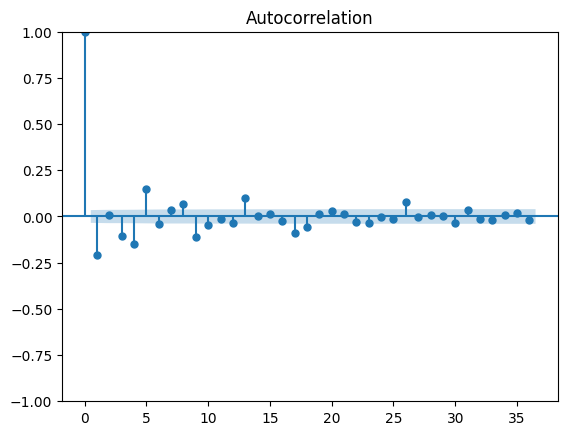

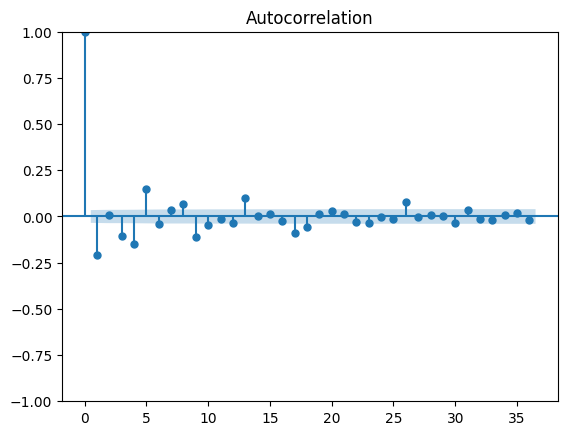

In [24]:
plot_acf(df_diff['Peak viewers'])

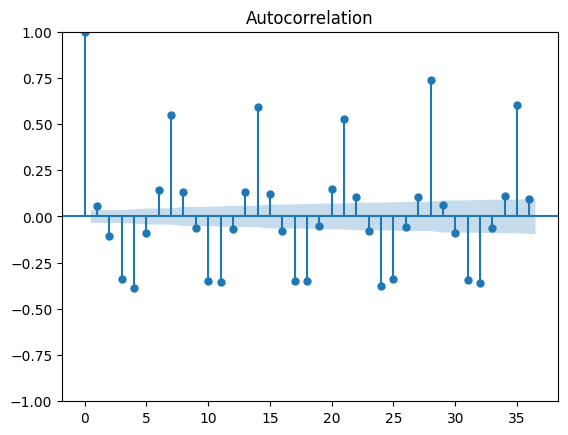

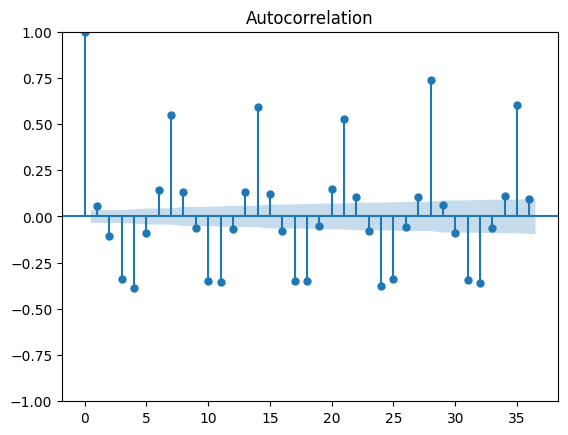

In [25]:
plot_acf(df_diff['Players'])

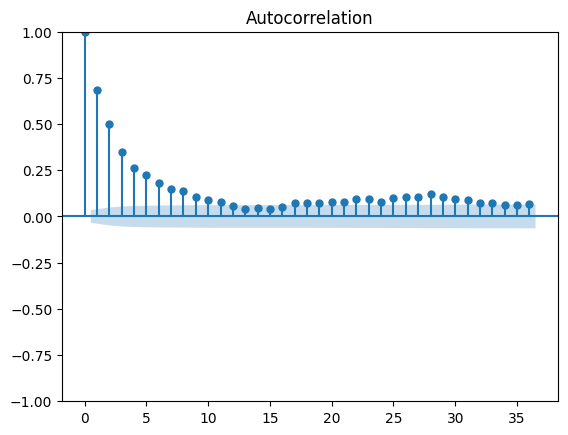

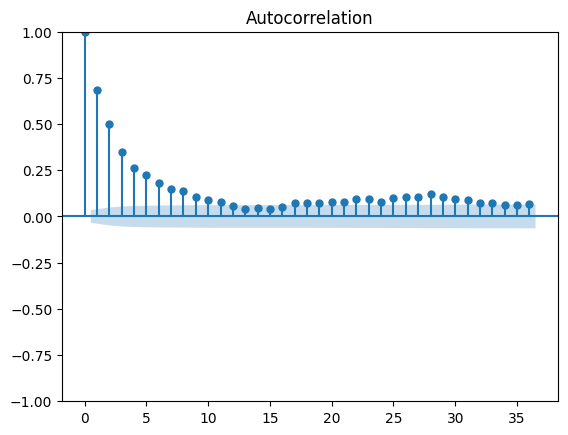

In [26]:
plot_acf(df_diff['Rating'])

In [27]:
Players = df_diff[['Players']]

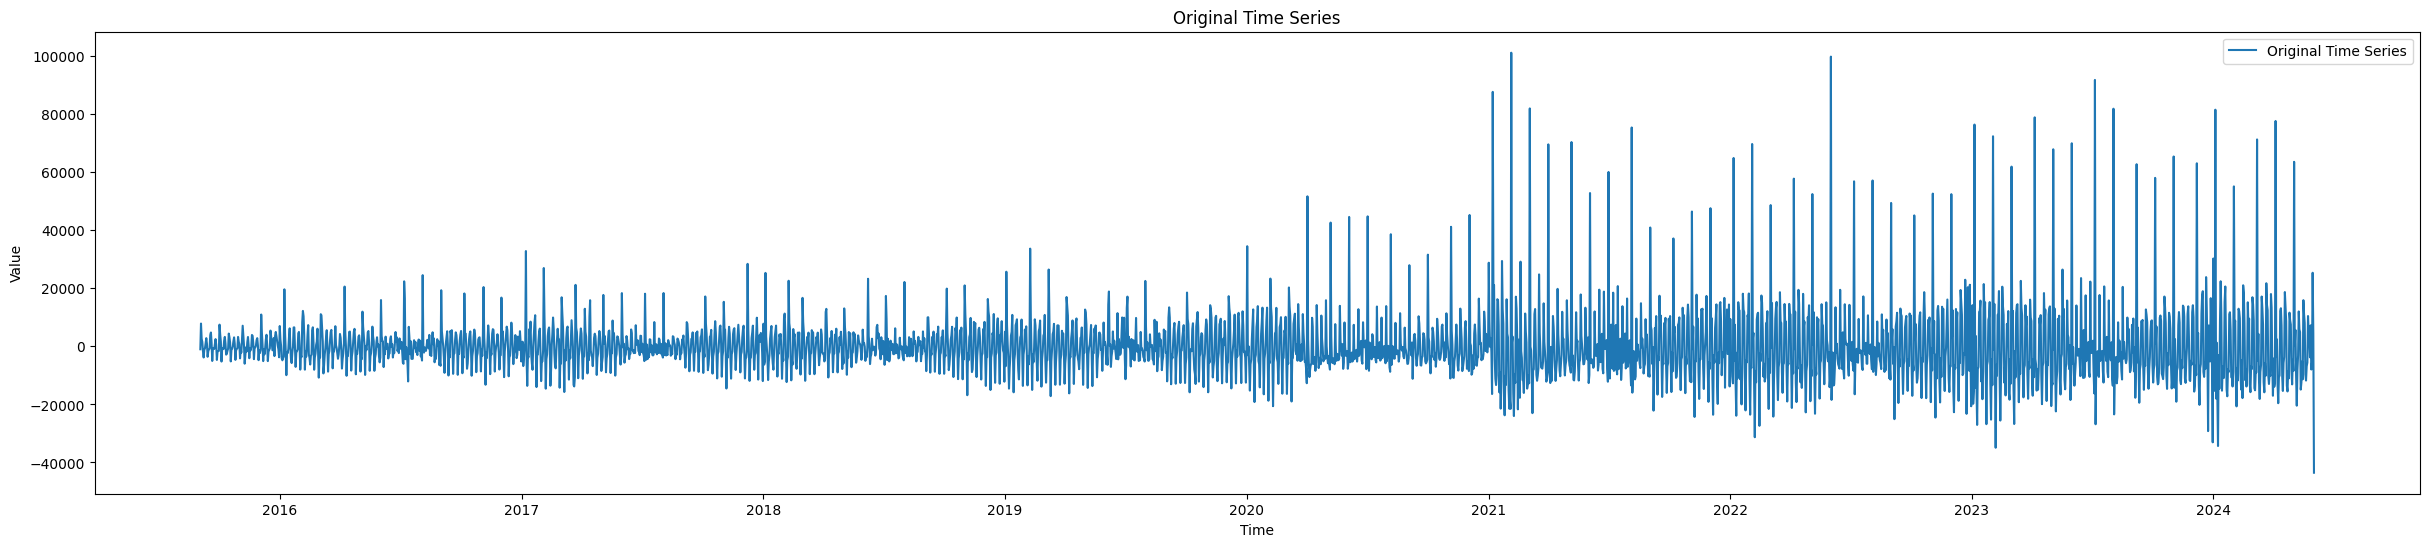

In [28]:
# Plot the original time series
plt.figure(figsize=(30, 6))
plt.plot(Players, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

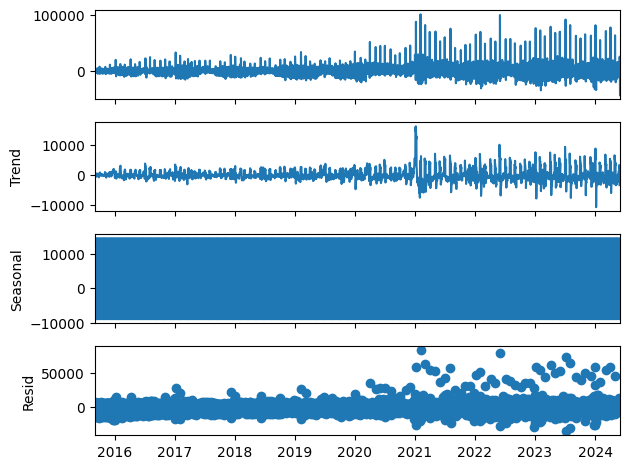

In [29]:
# Decompose the time series
result = seasonal_decompose(Players, model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [30]:
# Deseasonalize the time series
deseasonalized_player = Players['Players'] - result.seasonal

In [31]:
deseasonalized_player

DateTime
2015-09-03   -15563.978881
2015-09-04     2966.828027
2015-09-05    -1606.976997
2015-09-06     5556.023582
2015-09-07     7225.839998
                  ...     
2024-05-28    -2407.737383
2024-05-29     -427.998348
2024-05-30    10793.021119
2024-05-31     -311.171973
2024-06-01   -47736.976997
Length: 3195, dtype: float64

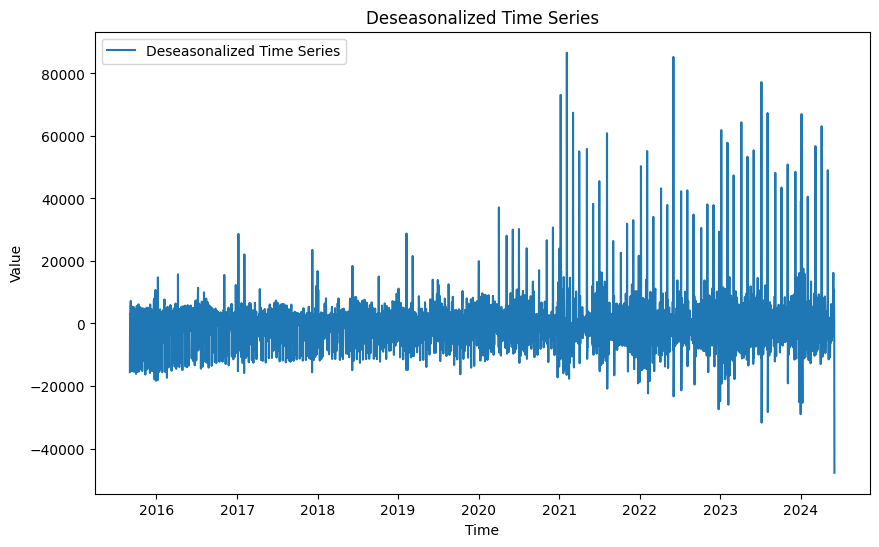

In [32]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_player, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [33]:
df_diff = pd.concat([df_diff, deseasonalized_player], axis=1)

In [34]:
df_diff

Peak viewers    Rating  Final price  Players  is_historical_low  \
DateTime                                                                      
2015-09-03         572.0 -0.002653          0.0   -998.0                  1   
2015-09-04        -489.0  0.005427          0.0   7857.0                  1   
2015-09-05        6722.0 -0.002167          0.0   2591.0                  1   
2015-09-06       -6729.0 -0.007311          0.0   1512.0                  1   
2015-09-07        7687.0 -0.015124          0.0  -1733.0                  1   
...                  ...       ...          ...      ...                ...   
2024-05-28        1232.0 -0.000162          0.0  -7968.0                  0   
2024-05-29      -41719.0 -0.002625          0.0  -5519.0                  0   
2024-05-30      -38653.0 -0.000337          0.0  25359.0                  0   
2024-05-31        5294.0 -0.000707          0.0   4579.0                  0   
2024-06-01      -96208.0 -0.000181          0.0 -43539.0                  0   

                       0  
DateTime                  
2015-09-03 -15563.978881  
2015-09-04   2966.828027  
2015-09-05  -1606.976997  
2015-09-06   5556.023582  
2015-09-07   7225.839998  
...                  ...  
2024-05-28  -2407.737383  
2024-05-29   -427.998348  
2024-05-30  10793.021119  
2024-05-31   -311.171973  
2024-06-01 -47736.976997  

[3195 rows x 6 columns]

In [35]:
df_diff.columns = ['Peak viewers', 'Rating', 'Final price',	'Players', 'is_historical_low', 'Deseasonalized_players']

In [36]:
df_diff = df_diff.drop('Players', axis = 1)

In [37]:
df_diff

Peak viewers    Rating  Final price  is_historical_low  \
DateTime                                                             
2015-09-03         572.0 -0.002653          0.0                  1   
2015-09-04        -489.0  0.005427          0.0                  1   
2015-09-05        6722.0 -0.002167          0.0                  1   
2015-09-06       -6729.0 -0.007311          0.0                  1   
2015-09-07        7687.0 -0.015124          0.0                  1   
...                  ...       ...          ...                ...   
2024-05-28        1232.0 -0.000162          0.0                  0   
2024-05-29      -41719.0 -0.002625          0.0                  0   
2024-05-30      -38653.0 -0.000337          0.0                  0   
2024-05-31        5294.0 -0.000707          0.0                  0   
2024-06-01      -96208.0 -0.000181          0.0                  0   

            Deseasonalized_players  
DateTime                            
2015-09-03           -15563.978881  
2015-09-04             2966.828027  
2015-09-05            -1606.976997  
2015-09-06             5556.023582  
2015-09-07             7225.839998  
...                            ...  
2024-05-28            -2407.737383  
2024-05-29             -427.998348  
2024-05-30            10793.021119  
2024-05-31             -311.171973  
2024-06-01           -47736.976997  

[3195 rows x 5 columns]

In [38]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [39]:
check_stationarity(df_diff['Deseasonalized_players'])

ADF Statistic: -10.835113391830356
p-value: 1.6697172243668732e-19
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<Axes: >

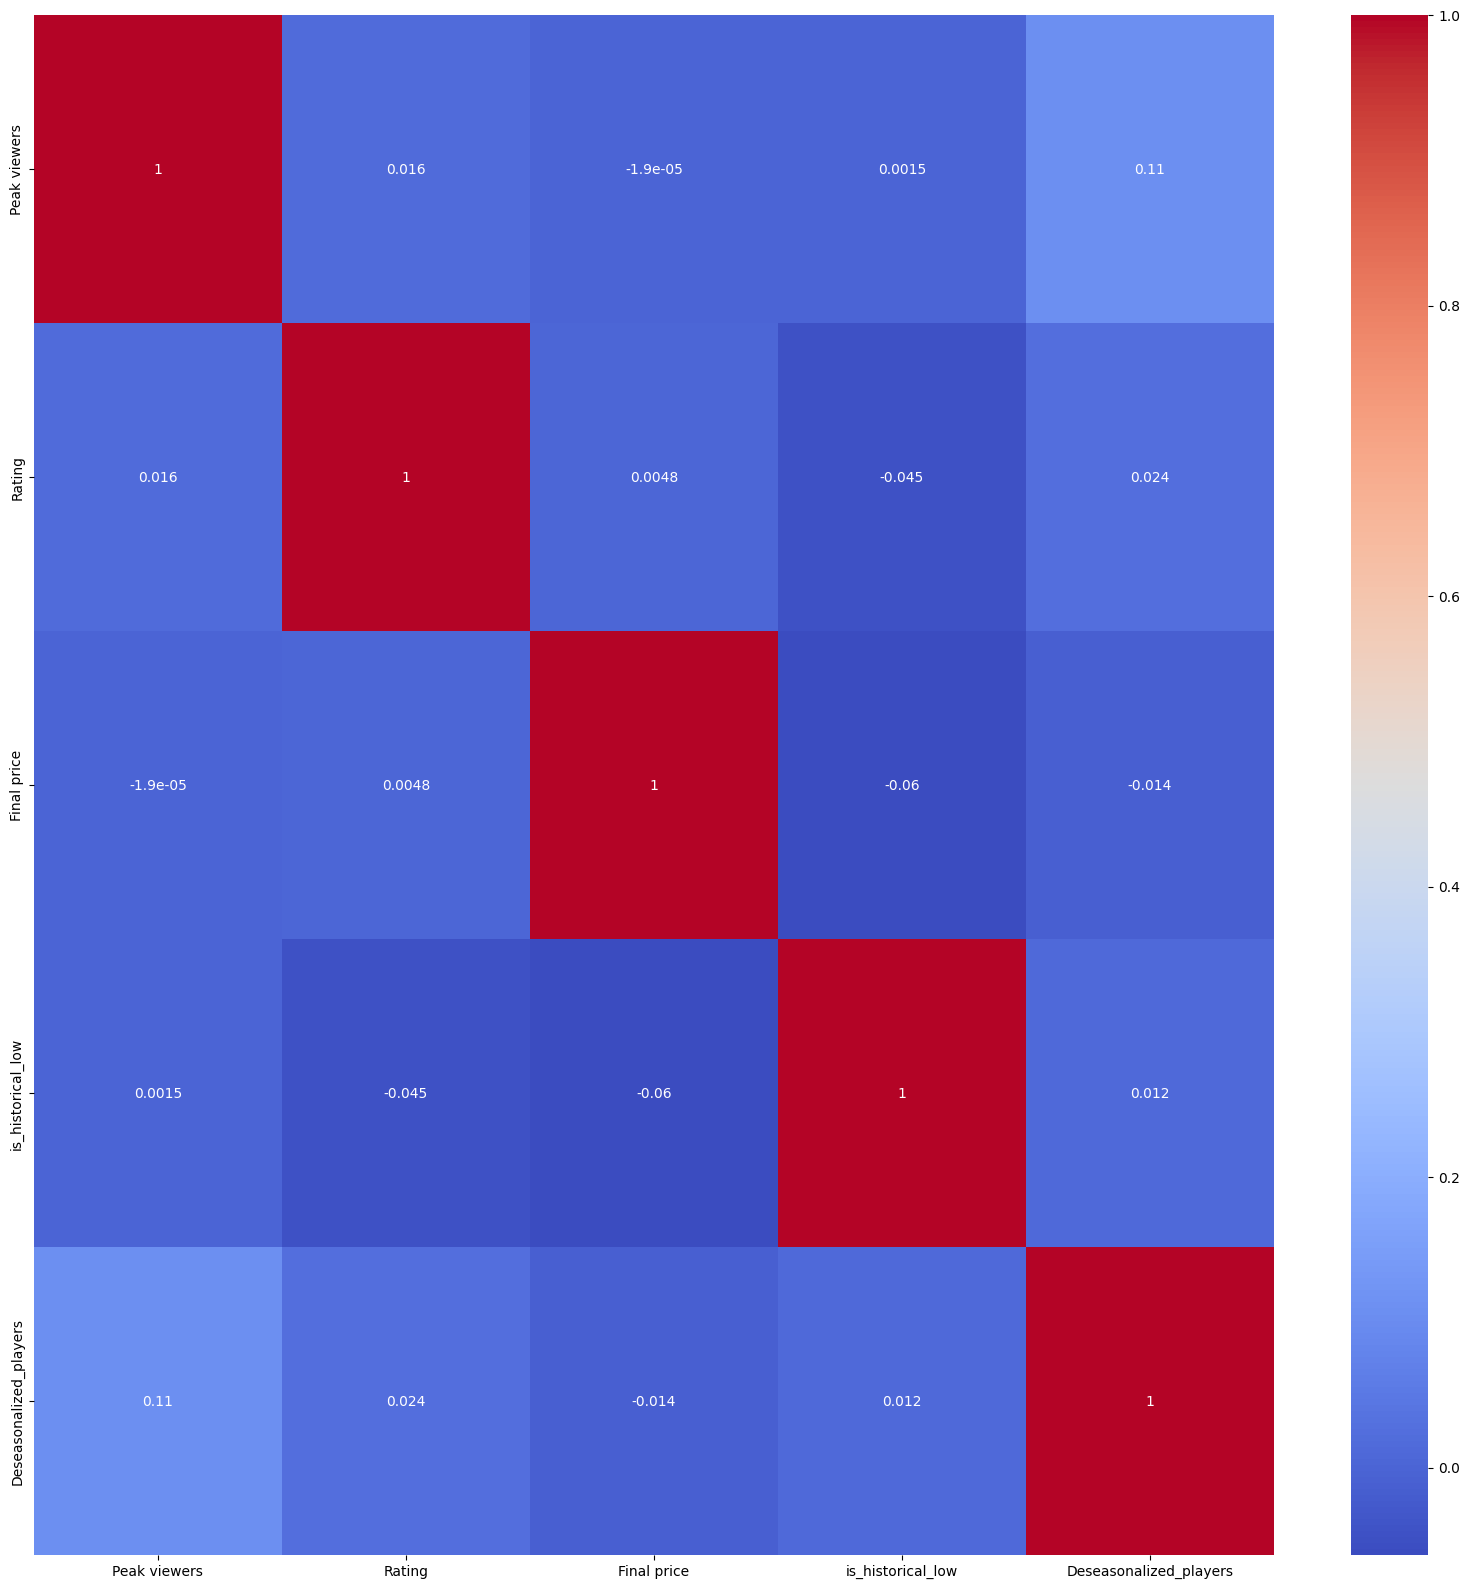

In [40]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_diff.corr(),
            annot = True,
            cmap = 'coolwarm')

In [41]:
for i in range(1,15):
    df_diff['Peak viewers_shift_' + str(i)] = df_diff['Peak viewers'].shift(i)
for i in range(1,8):
    df_diff['Rating_shift_' + str(i)] = df_diff['Rating'].shift(i)
for i in range(1,8):
    df_diff['Final price_shift_' + str(i)] = df_diff['Final price'].shift(i)
for i in range(1,8):
    df_diff['is_historical_low_shift_' + str(i)] = df_diff['is_historical_low'].shift(i)

In [42]:
df_diff = df_diff.dropna()

<Axes: >

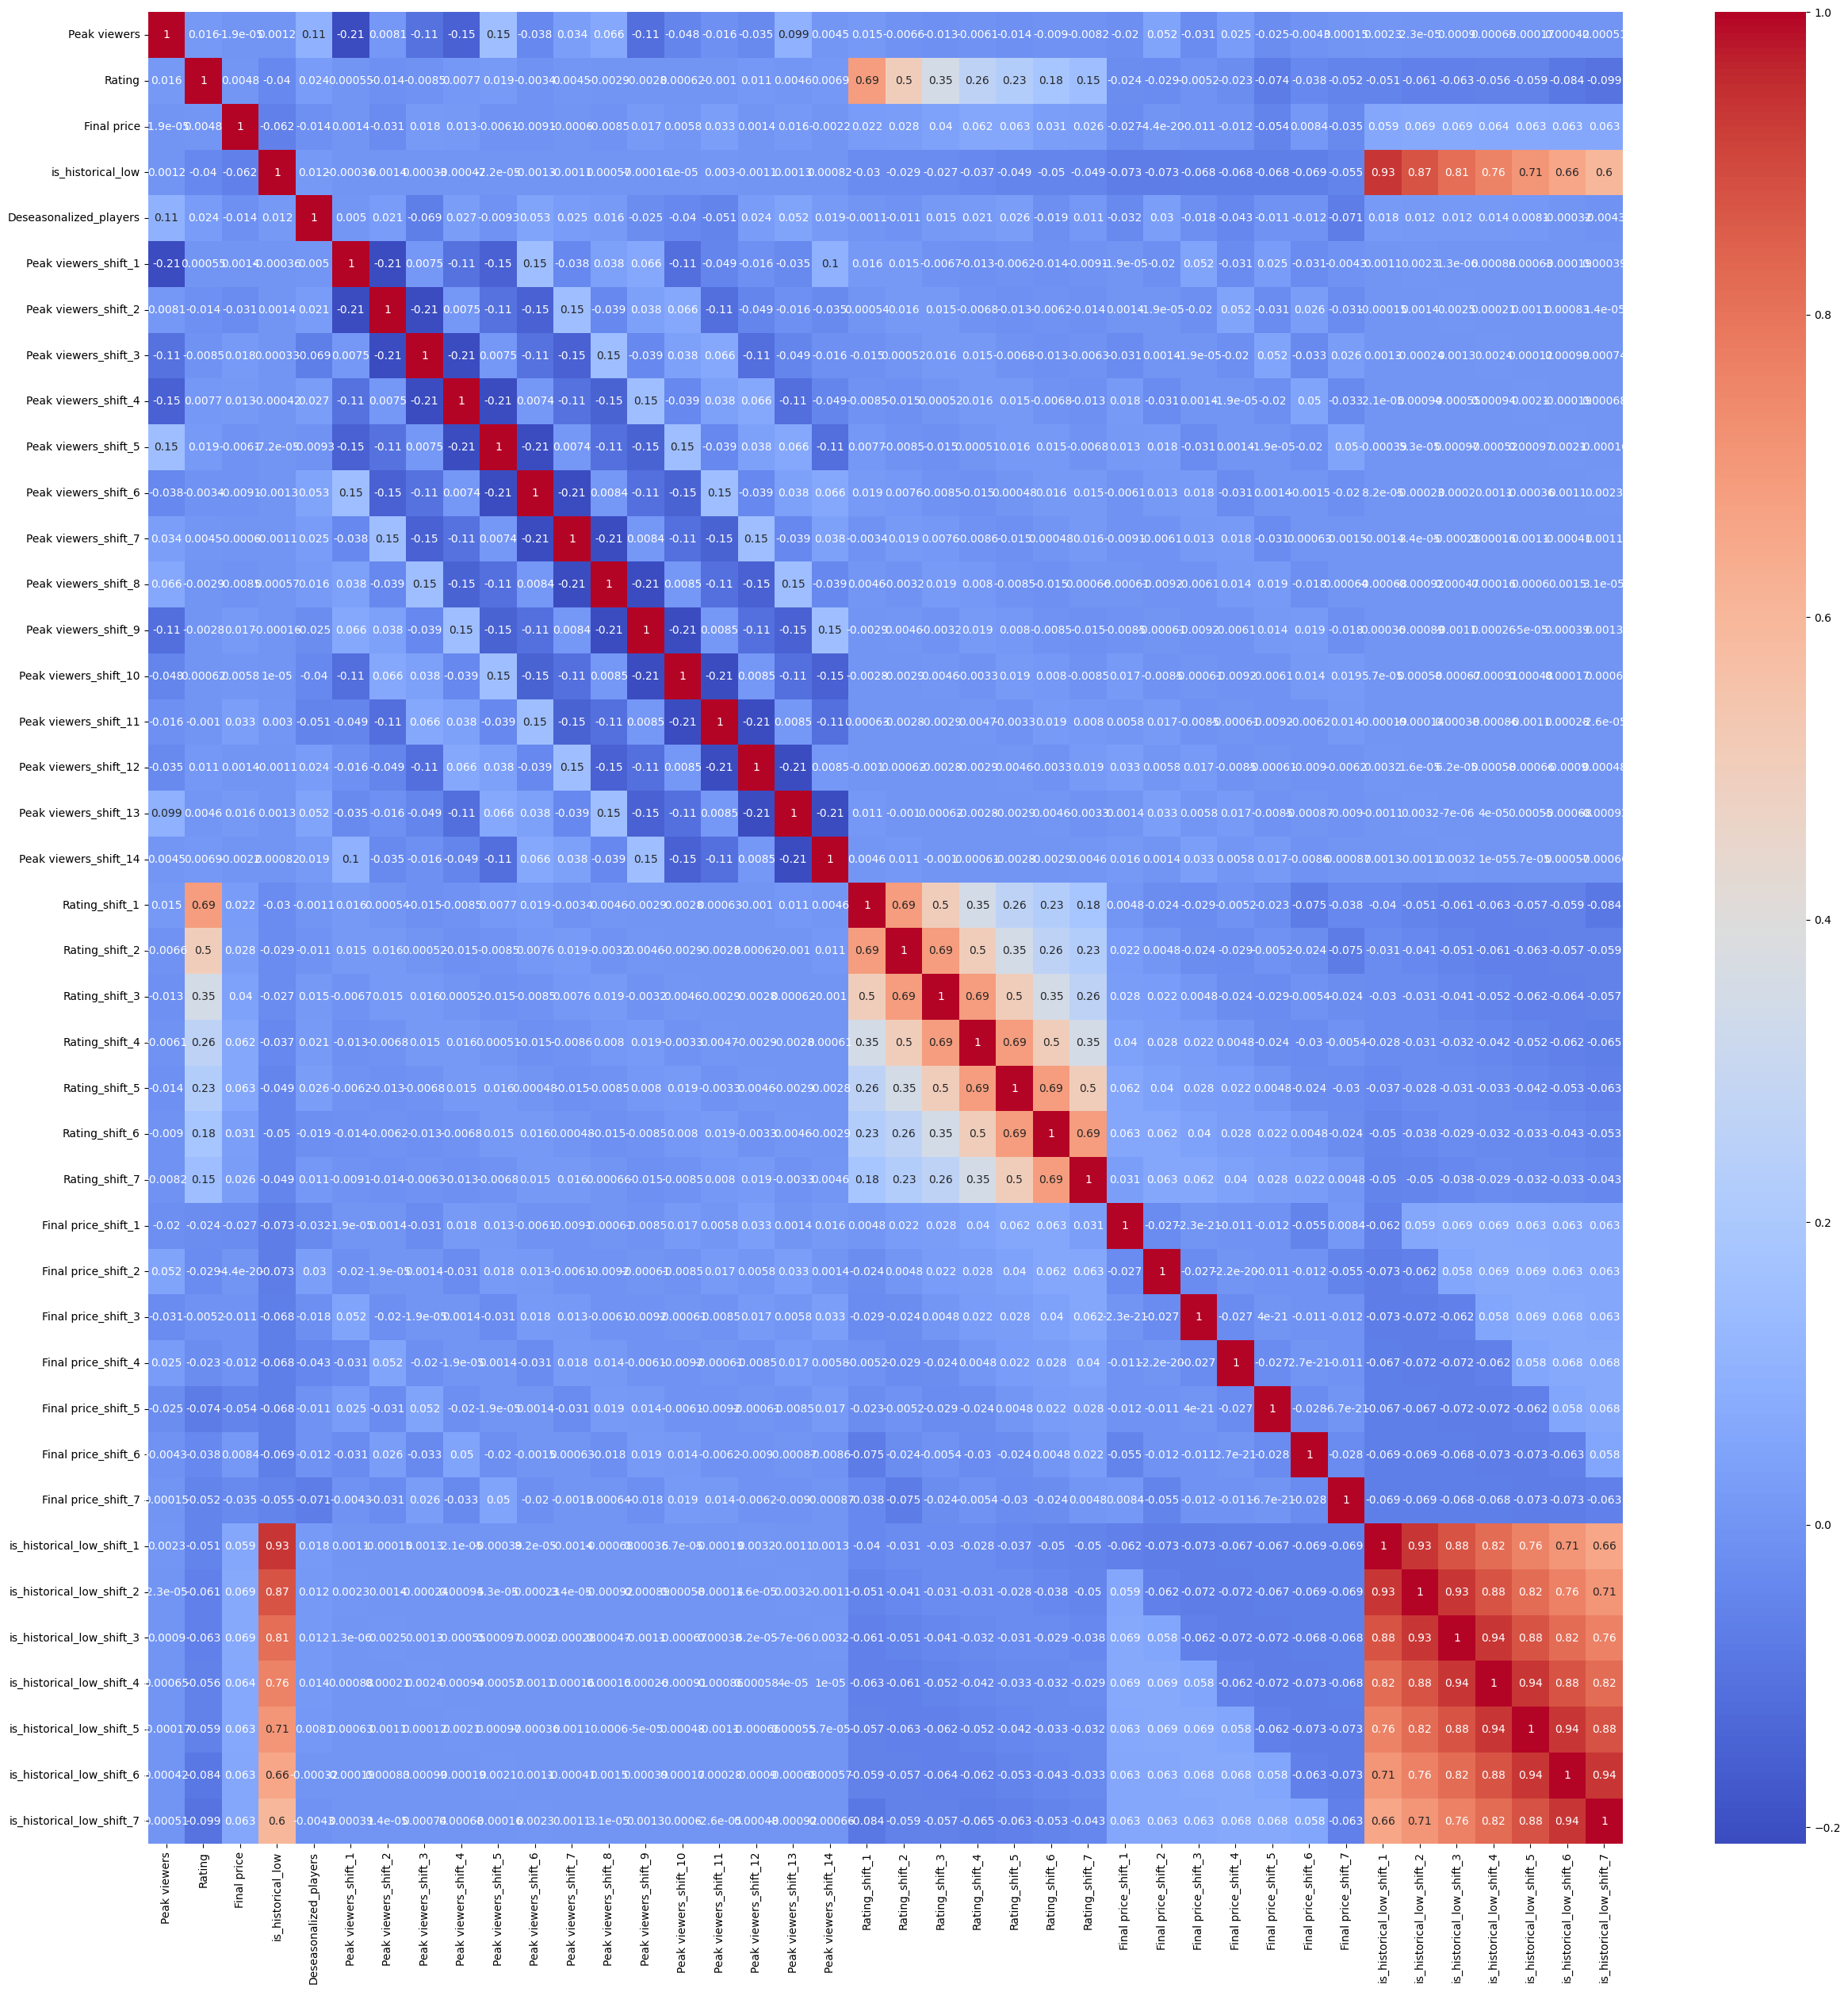

In [43]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_diff.corr(),
            annot = True,
            cmap = 'coolwarm')

In [44]:
df_diff.columns

Index(['Peak viewers', 'Rating', 'Final price', 'is_historical_low',
       'Deseasonalized_players', 'Peak viewers_shift_1',
       'Peak viewers_shift_2', 'Peak viewers_shift_3', 'Peak viewers_shift_4',
       'Peak viewers_shift_5', 'Peak viewers_shift_6', 'Peak viewers_shift_7',
       'Peak viewers_shift_8', 'Peak viewers_shift_9', 'Peak viewers_shift_10',
       'Peak viewers_shift_11', 'Peak viewers_shift_12',
       'Peak viewers_shift_13', 'Peak viewers_shift_14', 'Rating_shift_1',
       'Rating_shift_2', 'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5',
       'Rating_shift_6', 'Rating_shift_7', 'Final price_shift_1',
       'Final price_shift_2', 'Final price_shift_3', 'Final price_shift_4',
       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
       'is_historical_low_shift_1', 'is_historical_low_shift_2',
       'is_historical_low_shift_3', 'is_historical_low_shift_4',
       'is_historical_low_shift_5', 'is_historical_low_shift_6',
       'is_h

# 2. Linear Regression

In [45]:
df_linreg = raw[['Players', 'Day of the Week', 'Peak viewers', 'Rating', 'Final price', 'Tournament (INTL)', 'Events', 'is_historical_low', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]

In [46]:
# stationarize
df_linreg['Players'] = df_linreg['Players'].diff().dropna()
df_linreg['Peak viewers'] = df_linreg['Peak viewers'].diff().dropna()
df_linreg['Rating'] = df_linreg['Rating'].diff().dropna()
df_linreg['Final price'] = df_linreg['Final price'].diff().dropna()

In [47]:
df_linreg = df_linreg.iloc[1:]

In [48]:
df_linreg

Players Day of the Week  Peak viewers    Rating  Final price  \
1      -998.0        Thursday         572.0 -0.002653          0.0   
2      7857.0          Friday        -489.0  0.005427          0.0   
3      2591.0        Saturday        6722.0 -0.002167          0.0   
4      1512.0          Sunday       -6729.0 -0.007311          0.0   
5     -1733.0          Monday        7687.0 -0.015124          0.0   
...       ...             ...           ...       ...          ...   
3191  -7968.0         Tuesday        1232.0 -0.000162          0.0   
3192  -5519.0       Wednesday      -41719.0 -0.002625          0.0   
3193  25359.0        Thursday      -38653.0 -0.000337          0.0   
3194   4579.0          Friday        5294.0 -0.000707          0.0   
3195 -43539.0        Saturday      -96208.0 -0.000181          0.0   

      Tournament (INTL)  Events  is_historical_low  Friday  Monday  Saturday  \
1                     0       0                  1       0       0         0   
2                     0       0                  1       1       0         0   
3                     0       0                  1       0       0         1   
4                     0       0                  1       0       0         0   
5                     0       0                  1       0       1         0   
...                 ...     ...                ...     ...     ...       ...   
3191                  0       0                  0       0       0         0   
3192                  0       0                  0       0       0         0   
3193                  0       0                  0       0       0         0   
3194                  0       0                  0       1       0         0   
3195                  0       0                  0       0       0         1   

      Sunday  Thursday  Tuesday  Wednesday  
1          0         1        0          0  
2          0         0        0          0  
3          0         0        0          0  
4          1         0        0          0  
5          0         0        0          0  
...      ...       ...      ...        ...  
3191       0         0        1          0  
3192       0         0        0          1  
3193       0         1        0          0  
3194       0         0        0          0  
3195       0         0        0          0  

[3195 rows x 15 columns]

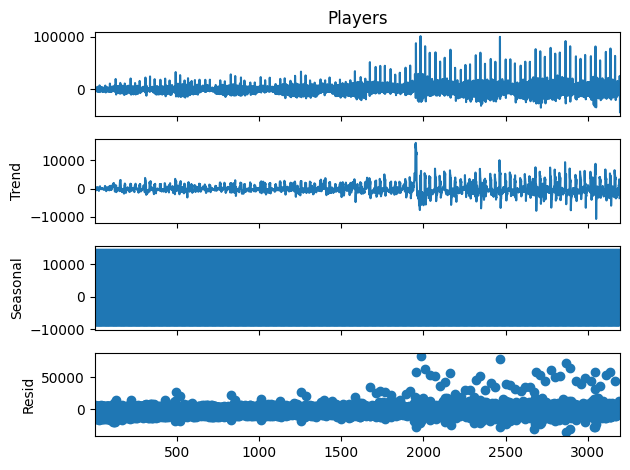

In [49]:
# Decompose the time series
result = seasonal_decompose(df_linreg['Players'], model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [50]:
df_linreg['Deseasonalized_players'] = df_linreg['Players'] - result.seasonal

In [51]:
df_granger = df_linreg

In [52]:
for i in range(1,15):
    df_linreg['Peak viewers_shift_' + str(i)] = df_linreg['Peak viewers'].shift(i)
for i in range(1,8):
    df_linreg['Rating_shift_' + str(i)] = df_linreg['Rating'].shift(i)
for i in range(1,8):
    df_linreg['Final price_shift_' + str(i)] = df_linreg['Final price'].shift(i)
for i in range(1,8):
    df_linreg['is_historical_low_shift_' + str(i)] = df_linreg['is_historical_low'].shift(i)

In [53]:
df_linreg = df_linreg.dropna()

In [54]:
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df_linreg['Day of the Week'] = df_linreg['Day of the Week'].map(day_mapping)

In [55]:
# model 1
x_1 = df_linreg[['Peak viewers', 'Rating', 'Final price',
       'Tournament (INTL)', 'Events', 'is_historical_low', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Peak viewers_shift_1',
       'Peak viewers_shift_2', 'Peak viewers_shift_3', 'Peak viewers_shift_4',
       'Peak viewers_shift_5', 'Peak viewers_shift_6', 'Peak viewers_shift_7',
       'Peak viewers_shift_8', 'Peak viewers_shift_9', 'Peak viewers_shift_10',
       'Peak viewers_shift_11', 'Peak viewers_shift_12',
       'Peak viewers_shift_13', 'Peak viewers_shift_14', 'Rating_shift_1',
       'Rating_shift_2', 'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5',
       'Rating_shift_6', 'Rating_shift_7', 'Final price_shift_1',
       'Final price_shift_2', 'Final price_shift_3', 'Final price_shift_4',
       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
       'is_historical_low_shift_1', 'is_historical_low_shift_2',
       'is_historical_low_shift_3', 'is_historical_low_shift_4',
       'is_historical_low_shift_5', 'is_historical_low_shift_6',
       'is_historical_low_shift_7']]

y = df_linreg['Deseasonalized_players']

x_1 = sm.add_constant(x_1)

model_1 = sm.OLS(y, x_1)
print(model_1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.044
Model:                                OLS   Adj. R-squared:                  0.030
Method:                     Least Squares   F-statistic:                     3.067
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           1.82e-11
Time:                            22:13:48   Log-Likelihood:                -33331.
No. Observations:                    3181   AIC:                         6.676e+04
Df Residuals:                        3133   BIC:                         6.705e+04
Df Model:                              47                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [56]:
# model 2  with only Peak viewers and its lags
x_2 = df_linreg[['Peak viewers', 'Peak viewers_shift_1', 'Peak viewers_shift_2', 'Peak viewers_shift_3',
       'Peak viewers_shift_4', 'Peak viewers_shift_5', 'Peak viewers_shift_6',
       'Peak viewers_shift_7', 'Peak viewers_shift_8', 'Peak viewers_shift_9',
       'Peak viewers_shift_10', 'Peak viewers_shift_11',
       'Peak viewers_shift_12', 'Peak viewers_shift_13',
       'Peak viewers_shift_14']]
y = df_linreg['Deseasonalized_players']

x_2 = sm.add_constant(x_2)

model_2 = sm.OLS(y, x_2)
print(model_2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.026
Model:                                OLS   Adj. R-squared:                  0.022
Method:                     Least Squares   F-statistic:                     5.721
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           8.99e-12
Time:                            22:13:48   Log-Likelihood:                -33360.
No. Observations:                    3181   AIC:                         6.675e+04
Df Residuals:                        3165   BIC:                         6.685e+04
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [57]:
# model 3 with only significant variables
x_3 = df_linreg[['Peak viewers', 'Rating', 'Final price',
       'Tournament (INTL)', 'Events', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Peak viewers_shift_4', 'Peak viewers_shift_6', 'Peak viewers_shift_11', 'Peak viewers_shift_13', 'Final price_shift_4',
       'is_historical_low']]

y = df_linreg['Deseasonalized_players']

x_3 = sm.add_constant(x_3)

model_3 = sm.OLS(y, x_3)
print(model_3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.025
Model:                                OLS   Adj. R-squared:                  0.020
Method:                     Least Squares   F-statistic:                     4.800
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           2.82e-10
Time:                            22:13:48   Log-Likelihood:                -33362.
No. Observations:                    3181   AIC:                         6.676e+04
Df Residuals:                        3163   BIC:                         6.687e+04
Df Model:                              17                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

# 3. Granger Casuality Test

In [58]:
df_granger

Players Day of the Week  Peak viewers    Rating  Final price  \
1      -998.0        Thursday         572.0 -0.002653          0.0   
2      7857.0          Friday        -489.0  0.005427          0.0   
3      2591.0        Saturday        6722.0 -0.002167          0.0   
4      1512.0          Sunday       -6729.0 -0.007311          0.0   
5     -1733.0          Monday        7687.0 -0.015124          0.0   
...       ...             ...           ...       ...          ...   
3191  -7968.0         Tuesday        1232.0 -0.000162          0.0   
3192  -5519.0       Wednesday      -41719.0 -0.002625          0.0   
3193  25359.0        Thursday      -38653.0 -0.000337          0.0   
3194   4579.0          Friday        5294.0 -0.000707          0.0   
3195 -43539.0        Saturday      -96208.0 -0.000181          0.0   

      Tournament (INTL)  Events  is_historical_low  Friday  Monday  ...  \
1                     0       0                  1       0       0  ...   
2                     0       0                  1       1       0  ...   
3                     0       0                  1       0       0  ...   
4                     0       0                  1       0       0  ...   
5                     0       0                  1       0       1  ...   
...                 ...     ...                ...     ...     ...  ...   
3191                  0       0                  0       0       0  ...   
3192                  0       0                  0       0       0  ...   
3193                  0       0                  0       0       0  ...   
3194                  0       0                  0       1       0  ...   
3195                  0       0                  0       0       0  ...   

      Final price_shift_5  Final price_shift_6  Final price_shift_7  \
1                     NaN                  NaN                  NaN   
2                     NaN                  NaN                  NaN   
3                     NaN                  NaN                  NaN   
4                     NaN                  NaN                  NaN   
5                     NaN                  NaN                  NaN   
...                   ...                  ...                  ...   
3191                  0.0                  0.0                  0.0   
3192                  0.0                  0.0                  0.0   
3193                  0.0                  0.0                  0.0   
3194                  0.0                  0.0                  0.0   
3195                -20.0                  0.0                  0.0   

      is_historical_low_shift_1  is_historical_low_shift_2  \
1                           NaN                        NaN   
2                           1.0                        NaN   
3                           1.0                        1.0   
4                           1.0                        1.0   
5                           1.0                        1.0   
...                         ...                        ...   
3191                        0.0                        0.0   
3192                        0.0                        0.0   
3193                        0.0                        0.0   
3194                        0.0                        0.0   
3195                        0.0                        0.0   

      is_historical_low_shift_3  is_historical_low_shift_4  \
1                           NaN                        NaN   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                           1.0                        NaN   
5                           1.0                        1.0   
...                         ...                        ...   
3191                        0.0                        0.0   
3192                        0.0                        0.0   
3193                        0.0                        0.0   
3194                        0.0               

In [59]:
from statsmodels.tsa.api import VAR

## Granger-causality test
model = VAR(df_granger[['Peak viewers', 'Deseasonalized_players']])
lag_order = model.select_order(maxlags=15)
print('AIC selected lag order:', lag_order.aic)

AIC selected lag order: 15


In [60]:
gc_res1 = grangercausalitytests(df_granger[['Deseasonalized_players', 'Peak viewers']], maxlag=lag_order.aic)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9262  , p=0.3359  , df_denom=3191, df_num=1
ssr based chi2 test:   chi2=0.9271  , p=0.3356  , df=1
likelihood ratio test: chi2=0.9270  , p=0.3357  , df=1
parameter F test:         F=0.9262  , p=0.3359  , df_denom=3191, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4230  , p=0.0045  , df_denom=3188, df_num=2
ssr based chi2 test:   chi2=10.8630 , p=0.0044  , df=2
likelihood ratio test: chi2=10.8446 , p=0.0044  , df=2
parameter F test:         F=5.4230  , p=0.0045  , df_denom=3188, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9179  , p=0.0001  , df_denom=3185, df_num=3
ssr based chi2 test:   chi2=20.7994 , p=0.0001  , df=3
likelihood ratio test: chi2=20.7319 , p=0.0001  , df=3
parameter F test:         F=6.9179  , p=0.0001  , df_denom=3185, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5458  , p=0.

# 4. Causal Discovery using Model Invariance (CDMI)

In [61]:
X = df_diff[['Peak viewers',  'Final price', 'is_historical_low', 
                       'Peak viewers_shift_1',
                       'Peak viewers_shift_2', 'Peak viewers_shift_3',
                       'Peak viewers_shift_4', 'Peak viewers_shift_5',
                       'Peak viewers_shift_6', 'Peak viewers_shift_7',
                       'Peak viewers_shift_8', 'Peak viewers_shift_9',
                       'Peak viewers_shift_10', 'Peak viewers_shift_11',
                       'Peak viewers_shift_12', 'Peak viewers_shift_13',
                       'Peak viewers_shift_14',
                       'Rating_shift_1', 'Rating_shift_7',
                       'Final price_shift_1', 'Final price_shift_2',
                       'Final price_shift_3', 'Final price_shift_4',
                       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
                       'is_historical_low_shift_1', 'is_historical_low_shift_2',
                       'is_historical_low_shift_3', 'is_historical_low_shift_4',
                       'is_historical_low_shift_5', 'is_historical_low_shift_6',
                       'is_historical_low_shift_7']]

X = X.drop(X.index[-1])
# Cannot solve for knockoffs with 'Rating', thus chose to discard it. 

In [62]:
#X = deseasonalized_df.drop(['Players_deseasonalized', 'Players'], axis = 1)
#X = X.drop(columns=[col for col in X.columns if 'Final price' in col])
y = df_diff['Deseasonalized_players']

In [63]:
# Initialize TimeSeriesSplit with 4 splits
tscv = TimeSeriesSplit(n_splits=4)

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [64]:
# Start Artificial Neural Network
model = keras.Sequential()

# Adding the input layer and the first hidden layer
model.add(keras.layers.Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the second hidden layer
model.add(keras.layers.Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the third hidden layer
model.add(keras.layers.Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the output layer
model.add(keras.layers.Dense(units=1, activation='linear'))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Specify optimizer with learning rate schedule
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile NN
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10)
]

In [66]:
history = model.fit(X_train, y_train, epochs= 100, batch_size = 50, validation_data = (X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
51/51 [==============================] - 1s 4ms/step - loss: 392379552.0000 - mae: 8823.1455 - val_loss: 197189264.0000 - val_mae: 8878.6826
Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 240982128.0000 - mae: 7402.9341 - val_loss: 171314560.0000 - val_mae: 8018.5786
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 226923760.0000 - mae: 6895.0811 - val_loss: 160218304.0000 - val_mae: 7891.8984
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 145559232.0000 - mae: 6456.8618 - val_loss: 157014336.0000 - val_mae: 7756.1948
Epoch 5/100
51/51 [==============================] - 0s 1ms/step - loss: 105572808.0000 - mae: 5987.7773 - val_loss: 155635744.0000 - val_mae: 7802.6729
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 97438552.0000 - mae: 5884.9443 - val_loss: 152071360.0000 - val_mae: 7568.9443
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 101461224.

In [67]:
model.evaluate(X_train, y_train)

80/80 [==============================] - 0s 453us/step - loss: 56004356.0000 - mae: 4771.8398


[56004356.0, 4771.83984375]

In [68]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 524us/step - loss: 148969744.0000 - mae: 7349.3594


[148969744.0, 7349.359375]

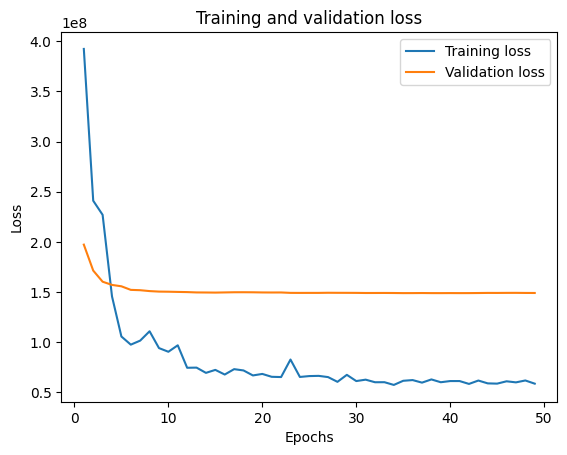

In [69]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="Training loss")
plt.plot(epochs, val_loss_values, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [70]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1,1), np.array(y_pred).reshape(-1,1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
predictions = model.predict(X_train)

mean_absolute_percentage_error(y_train, predictions)

80/80 [==============================] - 0s 422us/step


107.85483991393735

In [72]:
# Start Artificial Neural Network
final_model = keras.Sequential()

# Adding the input layer and the first hidden layer
final_model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
final_model.add(keras.layers.Dropout(0.5))

# Adding the second hidden layer
final_model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
final_model.add(keras.layers.Dropout(0.5))

# Adding the third hidden layer
final_model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
final_model.add(keras.layers.Dropout(0.5))

# Adding the output layer
final_model.add(keras.layers.Dense(units=1, activation='linear'))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Specify optimizer with learning rate schedule
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile NN
final_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [73]:
with open('dnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: C:\Users\YIXUAN~1\AppData\Local\Temp\tmpyi0salgv\assets


INFO:tensorflow:Assets written to: C:\Users\YIXUAN~1\AppData\Local\Temp\tmpyi0salgv\assets


In [74]:
with open('dnn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(X)
print(predictions)

100/100 [==============================] - 0s 453us/step
[[ 3.7891884e+01]
 [ 8.2456172e-01]
 [ 5.1573743e+02]
 ...
 [ 7.7176880e+01]
 [-1.1119940e+03]
 [ 1.0817721e+02]]


In [75]:
# Define parameters
params = {
    'length': len(X),
    'dim': X.shape[1],
    'col': X.columns
}

# Initialize the Knockoffs object
knockoff_generator = Knockoffs()

# Generate knockoff variables
knockoff_variables = knockoff_generator.GenKnockoffs(X.values, params)

# Convert to DataFrame for easier handling
X_knockoff = pd.DataFrame(knockoff_variables, columns=X.columns)

print(X_knockoff.head())

   Peak viewers  Final price  is_historical_low  Peak viewers_shift_1  \
0 -65810.644940     3.096644           0.819020          24428.094102   
1  -3097.915655     1.541049           0.839563          45612.217277   
2 -32594.303592    -0.263657           0.997472          -7667.034975   
3 -42881.099626    -0.170890           0.878825          -2255.559963   
4  15320.083535     0.677695           0.909507         -79007.947038   

   Peak viewers_shift_2  Peak viewers_shift_3  Peak viewers_shift_4  \
0         -22583.723222         -20674.411111          41595.619357   
1         -11120.982090         -17059.804373          51515.107383   
2          47079.926036         -57271.842693          18550.862280   
3         -29047.431210          66892.441301          -2837.126819   
4          18697.773987         -54638.969453          67692.043229   

   Peak viewers_shift_5  Peak viewers_shift_6  Peak viewers_shift_7  ...  \
0          -4672.121939         -16241.038635         -444

In [76]:
import torch

from diagnostics import compute_diagnostics, ScatterCovariance

# Assuming X and X_knockoff are your original and knockoff variables

# Define alphas for MMD
alphas = [1., 2., 4., 8., 16., 32., 64., 128.]

# Convert data to torch tensors
X_t = torch.from_numpy(X.values).float()
X_knockoff_t = torch.from_numpy(X_knockoff.values).float()

# Compute diagnostics
results = compute_diagnostics(X_t, X_knockoff_t, alphas, verbose=True)
print(results)

(Self-corr) : 0.356587
Covariance.    Full swap: 254279849623290904576.000000
     MMD.    Full swap: 0.000000
     KNN.    Full swap: 0.965409
  Energy.    Full swap: 8171.687500
Covariance. Partial swap: 292013259101214605312.000000
     MMD. Partial swap: 0.000000
     KNN. Partial swap: 0.892767
  Energy. Partial swap: 6987.218750
       Metric     Swap         Value
0  Covariance     self  3.565873e-01
1  Covariance     full  2.542798e+20
2         MMD     full  0.000000e+00
3         KNN     full  9.654088e-01
4      Energy     full  8.171688e+03
5  Covariance  partial  2.920133e+20
6         MMD  partial  0.000000e+00
7         KNN  partial  8.927673e-01
8      Energy  partial  6.987219e+03


In [77]:
def causal_inference_knockoff(X, y, X_knockoff, final_model, params):
    """
    Perform causal inference using knockoff intervention.
    
    Args:
    X: np.ndarray - Original features.
    y: np.ndarray - Target variable.
    X_knockoff: np.ndarray - Knockoff features.
    final_model: Trained model to predict y from X.
    params: dict - Dictionary of parameters.
    
    Returns:
    causal_matrix: np.ndarray - Thresholded causal matrix.
    p_matrix: np.ndarray - Matrix of p-values.
    """

    # Convert X and X_knockoff to numpy arrays if they are pandas DataFrames
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(X_knockoff, pd.DataFrame):
        X_knockoff = X_knockoff.values

    training_length = params.get('train_len')
    prediction_length = params.get('pred_len')
    num_windows = params.get('num_sliding_win')
    step_size = params.get('step_size')
    plot_path = params.get('plot_path')
    columns = params.get('col', [f'X{i}' for i in range(X.shape[1])])  # Default to 'X0', 'X1', ..., if 'col' is not provided
    num_samples = params.get('num_samples')
    
    if not training_length or not prediction_length or not num_windows or not step_size:
        raise ValueError("Missing required parameters in 'params' dictionary.")

    if not pathlib.Path(final_model).exists():
        raise FileNotFoundError(f"Model file {final_model} does not exist.")
    
    with open(final_model, 'rb') as f:
        model = pickle.load(f)
    
    causal_decisions = []
    p_values = []

    for i in range(X.shape[1]):
        feature_name = columns[i]
        print(f"Testing feature '{feature_name}' against target 'y'...")

        knockoff_sample = X_knockoff[:, i]
        mean = np.random.normal(0, 0.05, len(knockoff_sample)) + np.mean(X[:, i])
        outdist = np.random.normal(150, 120, len(knockoff_sample))
        uniform = np.random.uniform(np.min(X[:, i]), np.max(X[:, i]), len(knockoff_sample))
        interventionlist = [knockoff_sample, outdist[: len(knockoff_sample)], mean, uniform]
        intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']

        for m, intervene in enumerate(interventionlist):
            mselist, mselistint, mapelist, mapelistint = [], [], [], []
            for iter in range(num_windows):
                start = iter * step_size
                end = start + training_length + prediction_length

                X_train = X[start:start + training_length, :]
                y_train = y[start:start + training_length]
                X_test = X[start + training_length:end, :]
                y_test = y[start + training_length:end]

                X_test_int = X_test.copy()
                X_test_int[:, i] = intervene[start + training_length:end]

                y_pred = model.predict(X_test)
                y_pred_int = model.predict(X_test_int)

                mse = mean_squared_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)
                mseint = mean_squared_error(y_test, y_pred_int)
                mapeint = mean_absolute_percentage_error(y_test, y_pred_int)

                mselist.append(mse)
                mapelist.append(mape)
                mselistint.append(mseint)
                mapelistint.append(mapeint)

            # Statistical tests
            t, p = ks_2samp(mapelist, mapelistint)
            corr, p_val = spearmanr(mapelist, mapelistint)

            print(f"  Method: {intervention_methods[m]}, KS p-value: {p:.4f}, Spearman p-value: {p_val:.4f}")

            if p < 0.05:
                causal_decision = 1
            else:
                causal_decision = 0

            causal_decisions.append(causal_decision)
            p_values.append(p)

    # Reshape results into a matrix
    causal_matrix = np.array(causal_decisions).reshape(X.shape[1], len(intervention_methods))
    p_matrix = np.array(p_values).reshape(X.shape[1], len(intervention_methods))

    # Print summary
    print("\nCausal Inference Summary:")
    for i in range(X.shape[1]):
        feature_name = columns[i]
        print(f"Feature '{feature_name}':")
        for m in range(len(intervention_methods)):
            print(f"  {intervention_methods[m]} - Causal Decision: {causal_matrix[i, m]}, P-Value: {p_matrix[i, m]:.4f}")

    return causal_matrix, p_matrix

# Example usage:
# params = {
#     'train_len': 100,
#     'pred_len': 10,
#     'num_sliding_win': 30,
#     'step_size': 10,
#     'plot_path': './plots/',
#     'col': ['X1', 'X2', 'X3', 'X4'],
#     'num_samples': 50
# }
# causal_matrix, p_matrix = causal_inference_knockoff(X, y, X_knockoff, 'final_model.pkl', params)



In [78]:
default_params = {
    'epochs': 50,
    'pred_len': 12,
    'train_len': 500,
    'num_layers': 4,
    'num_samples': 40,
    'num_cells': 20,
    'dropout_rate': 0.1,
    'win_size': 1,
    'step_size': 3,
    'num_sliding_win': 20,
    'sliding_win_size': 100,
    'dim': 5,
    'batch_size': 32
}

In [79]:
causal_matrix, p_matrix = causal_inference_knockoff(X, y, X_knockoff, 'dnn_model.pkl', default_params)

Testing feature 'X0' against target 'y'...
1/1 [==============================] - 0s 12ms/step
  Method: In-dist, KS p-value: 0.3356, Spearman p-value: 0.4015
1/1 [==============================] - 0s 13ms/step
  Method: Out-dist, KS p-value: 0.3356, Spearman p-value: 0.0007
1/1 [==============================] - 0s 12ms/step
  Method: Mean, KS p-value: 0.3356, Spearman p-value: 0.0009
1/1 [==============================] - 0s 12ms/step
  Method: Uniform, KS p-value: 0.0000, Spearman p-value: 0.9799
Testing feature 'X1' against target 'y'...
1/1 [==============================] - 0s 11ms/step
  Method: In-dist, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 12ms/step
  Method: Out-dist, KS p-value: 0.9831, Spearman p-value: 0.0000
1/1 [==============================] - 0s 12ms/step
  Method: Mean, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 12ms/step
  Method: Uniform, KS p-value: 1.0000, Spearman p-valu

In [80]:
# Print the results
print("Causal Matrix (Thresholded):")
print(causal_matrix)
print("P-Value Matrix:")
print(p_matrix)

Causal Matrix (Thresholded):
[[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 1]
 [1 0 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [1 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
P-Value Matrix:
[[3.35590981e-01 3.35590981e-01 3.35590981e-01 1.45088891e-11]
 [1.00000000e+00 9.83136877e-01 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 8.31969611e-01 1.00000000e+00 1.00000000e+00]
 [8.31969611e-01 5.71336005e-01 5.71336005e-01 8.10577116e-02]
 [5.71336005e-01 9.83136877e-01 9.83136877e-01 9.54696510e-06]
 [5.71336005e-01 8.31969611e-01 8.31969611e-01 1.74533006e-01]
 [3.35590981e-01 8.31969611e-01 8.31969611e-01 8.10577116e-02]
 [3.35416594e-02 5.71336005e-01 8.31969611e-01 1.45088891e-11]
 [1.22986126e-02 8.31969611e-01 8.31969611e-01 5.80355564e-10]
 [3.35590981e-01 8.31969

In [81]:
# Create a dataframe to match the column names with the output
causal_df = pd.DataFrame(causal_matrix, index=params['col'], columns=['In-dist', 'Out-dist', 'Mean', 'Uniform'])
p_values_df = pd.DataFrame(p_matrix, index=params['col'], columns=['In-dist', 'Out-dist', 'Mean', 'Uniform'])


In [82]:
causal_df

In-dist  Out-dist  Mean  Uniform
Peak viewers                     0         0     0        1
Final price                      0         0     0        0
is_historical_low                0         0     0        0
Peak viewers_shift_1             0         0     0        0
Peak viewers_shift_2             0         0     0        1
Peak viewers_shift_3             0         0     0        0
Peak viewers_shift_4             0         0     0        0
Peak viewers_shift_5             1         0     0        1
Peak viewers_shift_6             1         0     0        1
Peak viewers_shift_7             0         0     0        1
Peak viewers_shift_8             0         0     0        0
Peak viewers_shift_9             0         0     0        1
Peak viewers_shift_10            0         0     0        0
Peak viewers_shift_11            0         0     0        1
Peak viewers_shift_12            0         0     0        0
Peak viewers_shift_13            0         0     0        1
Peak viewers_shift_14            1         0     0        1
Rating_shift_1                   0         0     0        0
Rating_shift_7                   0         0     0        0
Final price_shift_1              0         0     0        0
Final price_shift_2              0         0     0        0
Final price_shift_3              0         0     0        0
Final price_shift_4              0         0     0        0
Final price_shift_5              0         0     0        0
Final price_shift_6              0         0     0        0
Final price_shift_7              0         0     0        0
is_historical_low_shift_1        0         0     0        0
is_historical_low_shift_2        0         0     0        0
is_historical_low_shift_3        0         0     0        0
is_historical_low_shift_4        0         0     0        0
is_historical_low_shift_5        0         0     0        0
is_historical_low_shift_6        0         0     0        0
is_historical_low_shift_7        0         0     0        0

In [83]:
p_values_df

In-dist  Out-dist      Mean       Uniform
Peak viewers               0.335591  0.335591  0.335591  1.450889e-11
Final price                1.000000  0.983137  1.000000  1.000000e+00
is_historical_low          1.000000  0.831970  1.000000  1.000000e+00
Peak viewers_shift_1       0.831970  0.571336  0.571336  8.105771e-02
Peak viewers_shift_2       0.571336  0.983137  0.983137  9.546965e-06
Peak viewers_shift_3       0.571336  0.831970  0.831970  1.745330e-01
Peak viewers_shift_4       0.335591  0.831970  0.831970  8.105771e-02
Peak viewers_shift_5       0.033542  0.571336  0.831970  1.450889e-11
Peak viewers_shift_6       0.012299  0.831970  0.831970  5.803556e-10
Peak viewers_shift_7       0.335591  0.831970  0.831970  2.704973e-04
Peak viewers_shift_8       0.335591  0.335591  0.335591  8.105771e-02
Peak viewers_shift_9       0.571336  0.335591  0.335591  1.433478e-07
Peak viewers_shift_10      0.571336  0.831970  0.831970  1.745330e-01
Peak viewers_shift_11      0.335591  0.831970  0.831970  1.115802e-03
Peak viewers_shift_12      0.335591  0.571336  0.571336  8.105771e-02
Peak viewers_shift_13      0.831970  0.335591  0.335591  1.325967e-06
Peak viewers_shift_14      0.001116  0.571336  0.831970  1.131693e-08
Rating_shift_1             1.000000  0.999992  1.000000  1.000000e+00
Rating_shift_7             1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_1        1.000000  1.000000  1.000000  1.000000e+00
Final price_shift_2        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_3        1.000000  1.000000  1.000000  1.000000e+00
Final price_shift_4        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_5        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_6        1.000000  0.999992  1.000000  1.000000e+00
Final price_shift_7        1.000000  0.983137  1.000000  1.000000e+00
is_historical_low_shift_1  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_2  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_3  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_4  1.000000  0.983137  1.000000  1.000000e+00
is_historical_low_shift_5  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_6  1.000000  0.999992  1.000000  1.000000e+00
is_historical_low_shift_7  1.000000  0.983137  1.000000  1.000000e+00

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp, spearmanr
import pickle
import pandas as pd
import pathlib
import tensorflow as tf
from tensorflow.keras.models import load_model

def plot_mape_distributions_for_variable(X, y, X_knockoff, final_model_path, params, variable_index):
    """
    Plot the MAPE distributions comparing original and knockoff interventions for a specific variable.
    
    Args:
    X: np.ndarray or pd.DataFrame - Original features.
    y: np.ndarray or pd.Series - Target variable.
    X_knockoff: np.ndarray or pd.DataFrame - Knockoff features.
    final_model_path: str - Path to the trained model file.
    params: dict - Dictionary of parameters.
    variable_index: int - Index of the variable to test.
    """
    # Convert X, y, and X_knockoff to numpy arrays if they are pandas DataFrames
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    if isinstance(X_knockoff, pd.DataFrame):
        X_knockoff = X_knockoff.values
        
    plot_path = params.get('plot_path')
    training_length = params['train_len']
    prediction_length = params['pred_len']
    num_windows = params['num_sliding_win']
    step_size = params['step_size']
    columns = params.get('col', [f'X{i}' for i in range(X.shape[1])])  # Default to 'X0', 'X1', ..., if 'col' is not provided

    feature_name = columns[variable_index]

    # Load the model (handle both traditional pickled models and Keras models)
    if final_model_path.endswith('.pkl'):
        with open(final_model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        model = load_model(final_model_path)

    knockoff_sample = X_knockoff[:, variable_index]
    mean = np.random.normal(0, 0.05, len(knockoff_sample)) + np.mean(X[:, variable_index])
    outdist = np.random.normal(150, 120, len(knockoff_sample))
    uniform = np.random.uniform(np.min(X[:, variable_index]), np.max(X[:, variable_index]), len(knockoff_sample))
    interventionlist = [knockoff_sample, outdist[: len(knockoff_sample)], mean, uniform]
    intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']

    mapelist = {method: [] for method in intervention_methods}
    mapelistint = {method: [] for method in intervention_methods}

    for m, intervene in enumerate(interventionlist):
        for iter in range(num_windows):
            start = iter * step_size
            end = start + training_length + prediction_length

            X_train = X[start:start + training_length, :]
            y_train = y[start:start + training_length]
            X_test = X[start + training_length:end, :]
            y_test = y[start + training_length:end]

            X_test_int = X_test.copy()
            X_test_int[:, variable_index] = intervene[start + training_length:end]

            y_pred = model.predict(X_test,verbose = 0)
            y_pred_int = model.predict(X_test_int, verbose = 0)

            mape = mean_absolute_percentage_error(y_test, y_pred)
            mapeint = mean_absolute_percentage_error(y_test, y_pred_int)

            mapelist[intervention_methods[m]].append(mape)
            mapelistint[intervention_methods[m]].append(mapeint)

    # Plot MAPE distributions for the specified variable
    plt.figure(figsize=(14, 7))
    for i, method in enumerate(intervention_methods):
        plt.subplot(2, 2, i+1)
        sns.kdeplot(mapelist[method], label='Original', color='blue', shade=True)
        sns.kdeplot(mapelistint[method], label='Knockoff', color='red', shade=True)
        plt.title(f"MAPE Distribution for {method}")
        plt.xlabel("MAPE")
        plt.ylabel("Density")
        plt.legend()
    
    plt.suptitle(f"MAPE Distributions for Feature '{feature_name}'")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_path}/mape_distributions_{feature_name}.png")
    plt.show()

# Example usage:
# params = {
#     'train_len': 100,
#     'pred_len': 10,
#     'num_sliding_win': 30,
#     'step_size': 10,
#     'plot_path': './plots/',
#     'col': ['X1', 'X2', 'X3', 'X4'],
#     'num_samples': 50
# }
# plot_mape_distributions_for_variable(X, y, X_knockoff, 'dnn_model.pkl', params, variable_index=7)


In [85]:
default_params = {
    'plot_path' : 'C:\\Users\\Yixuan Liu\\Downloads\\DSO 585',
    'epochs': 50,
    'pred_len': 12,
    'train_len': 500,
    'num_layers': 4,
    'num_samples': 40,
    'num_cells': 20,
    'dropout_rate': 0.1,
    'win_size': 1,
    'step_size': 3,
    'num_sliding_win': 20,
    'sliding_win_size': 100,
    'dim': 5,
    'batch_size': 32
}

In [86]:
indices_with_in_dist_1 = causal_df.reset_index().index[causal_df['In-dist'] == 1].tolist()
variables_with_in_dist_1 = causal_df.index[causal_df['In-dist'] == 1].tolist()

In [87]:
variables_with_in_dist_1

['Peak viewers_shift_5', 'Peak viewers_shift_6', 'Peak viewers_shift_14']

In [88]:
indices_with_in_dist_1

[7, 8, 16]

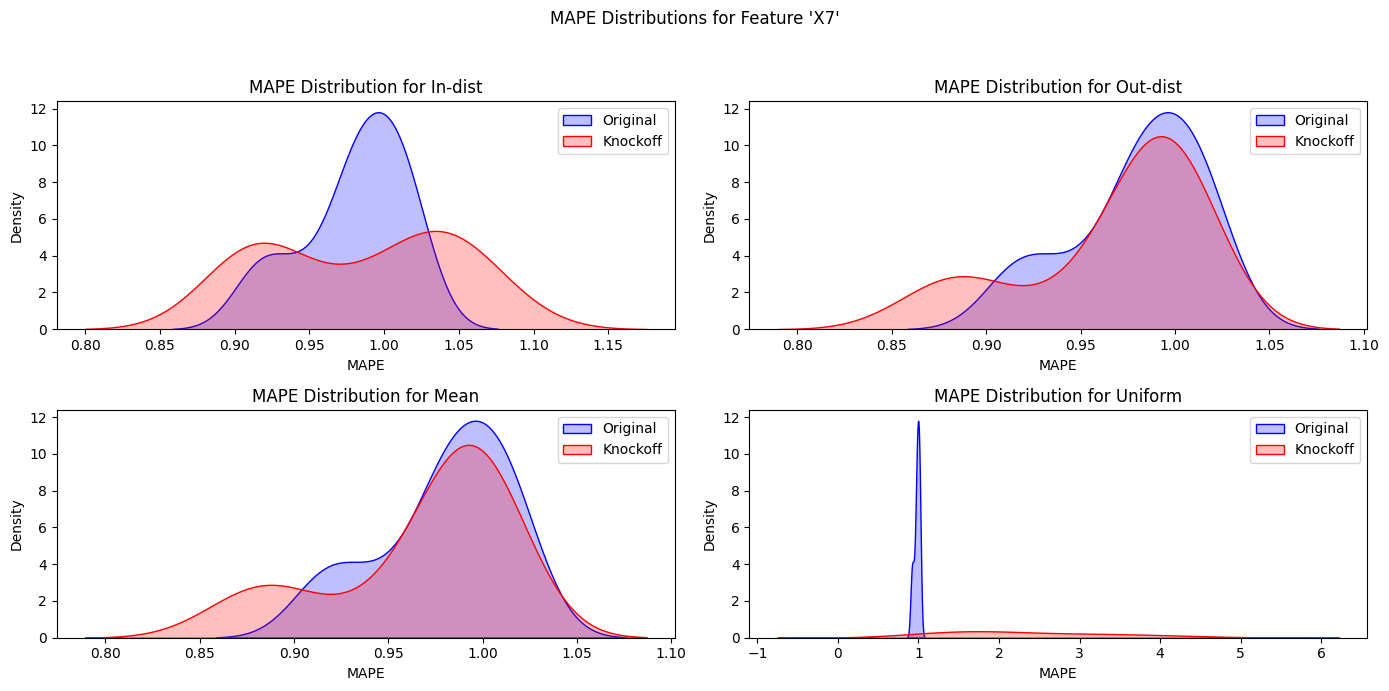

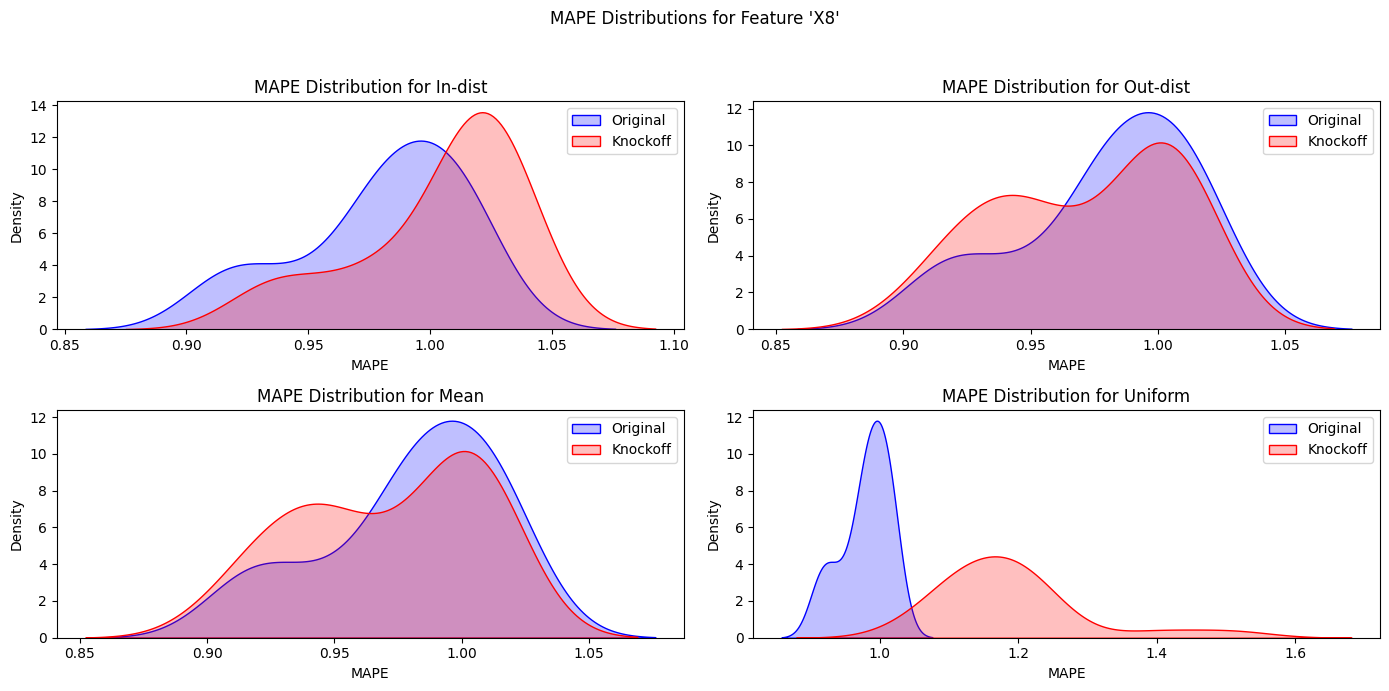

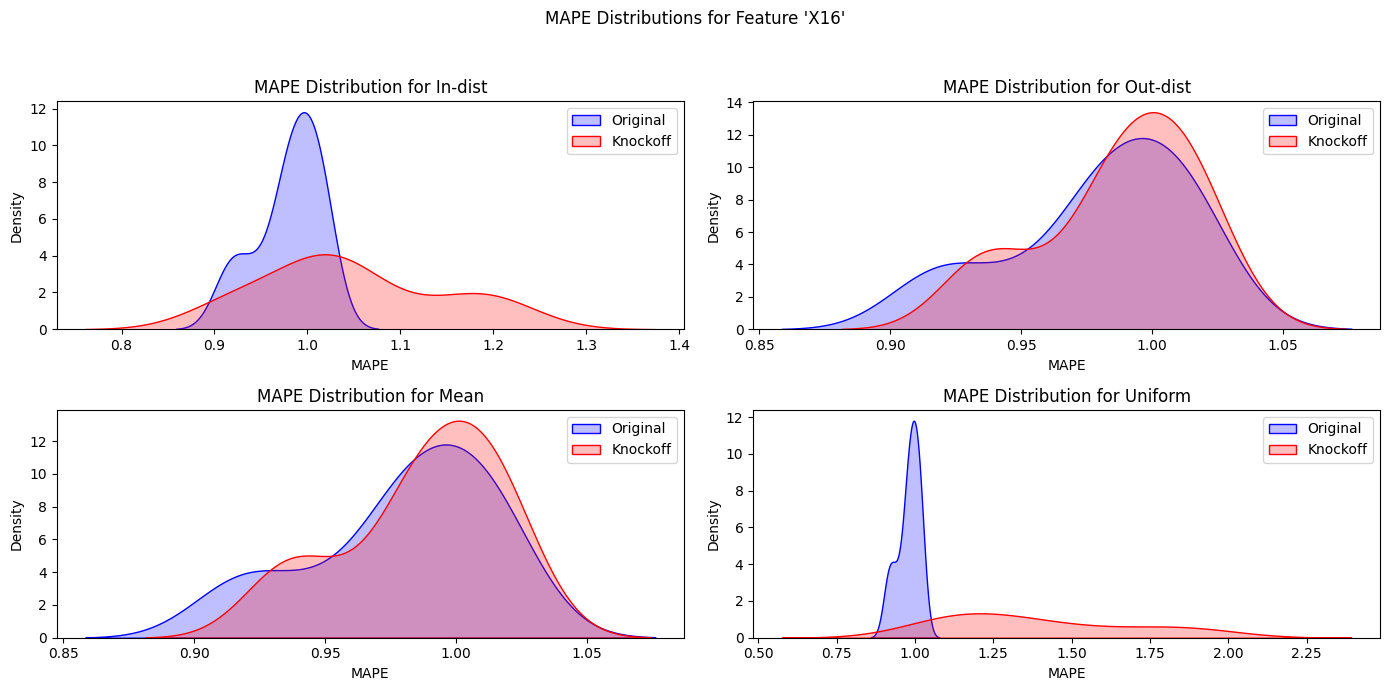

In [89]:
for i in range(len(indices_with_in_dist_1)):
    plot_mape_distributions_for_variable(X, y, X_knockoff, 'dnn_model.pkl', default_params, indices_with_in_dist_1[i])

# 5. LPCMCI

In [90]:
data = raw[['DateTime', 'Players', 'Peak viewers']]

In [91]:
data.loc[:, 'DateTime'] = pd.to_datetime(data['DateTime'], format='%m/%d/%y')

In [92]:
data = data.set_index('DateTime')

In [93]:
data = data.dropna()

In [94]:
data_diff = data.diff()

In [95]:
data_diff = data_diff.dropna()

<Axes: xlabel='DateTime'>

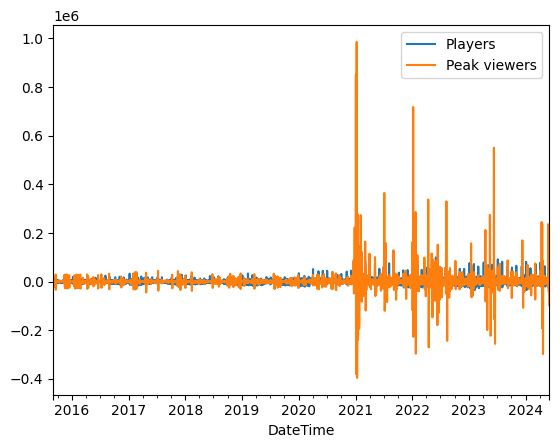

In [96]:
data_diff.plot()

In [97]:
Players = data_diff[['Players']]
Viewers = data_diff[['Peak viewers']]

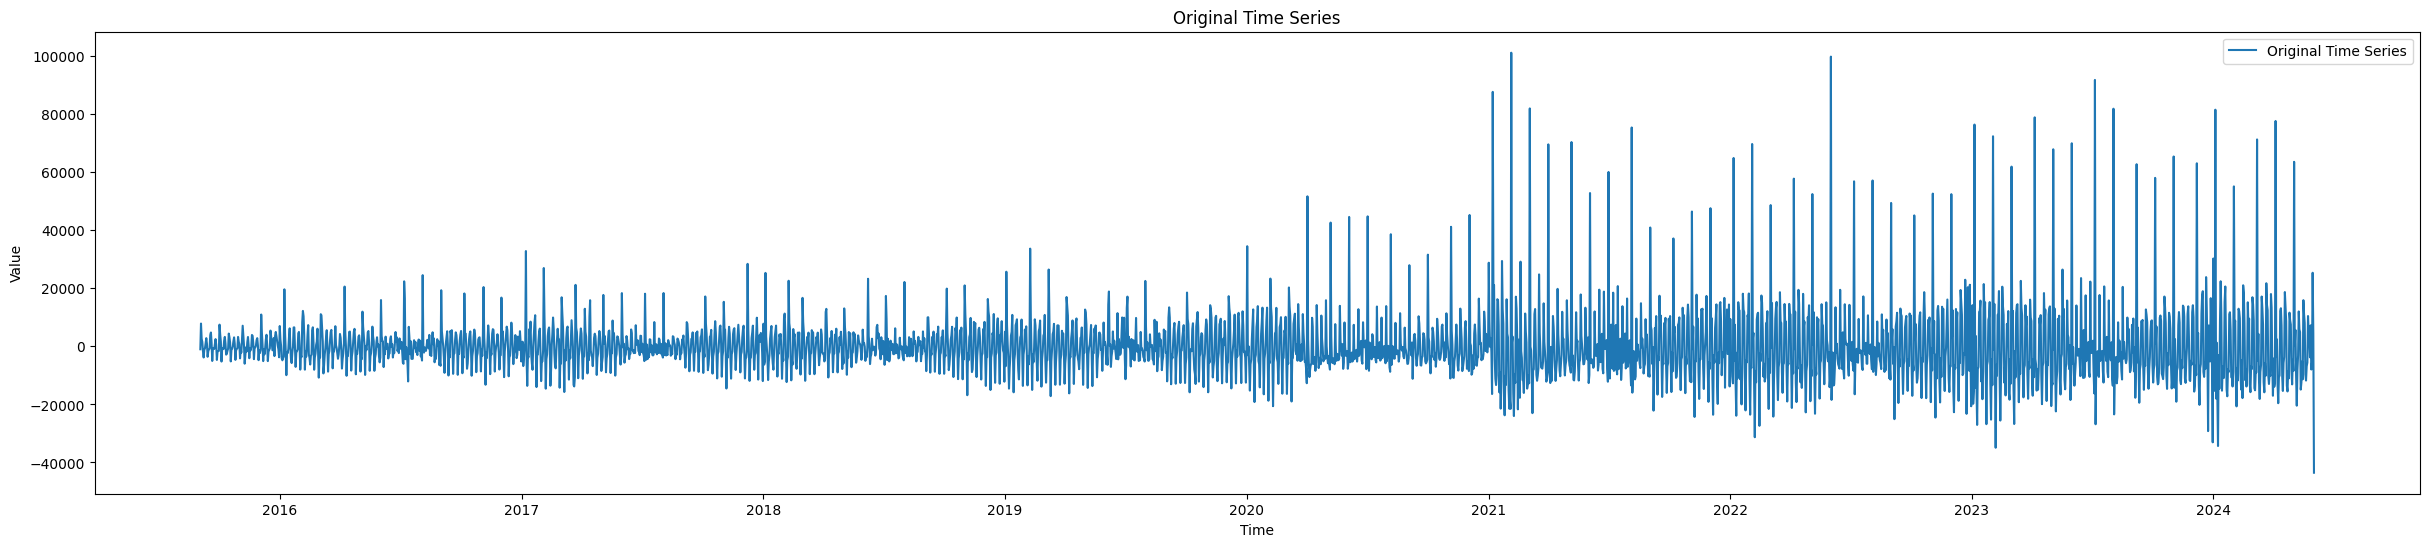

In [98]:
# Plot the original time series
plt.figure(figsize=(30, 6))
plt.plot(Players, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

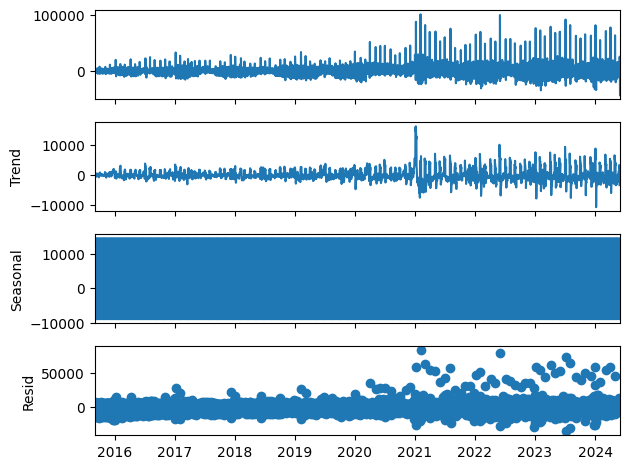

In [99]:
# Decompose the time series
result = seasonal_decompose(Players, model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [100]:
# Deseasonalize the time series
deseasonalized_player = Players['Players'] - result.seasonal

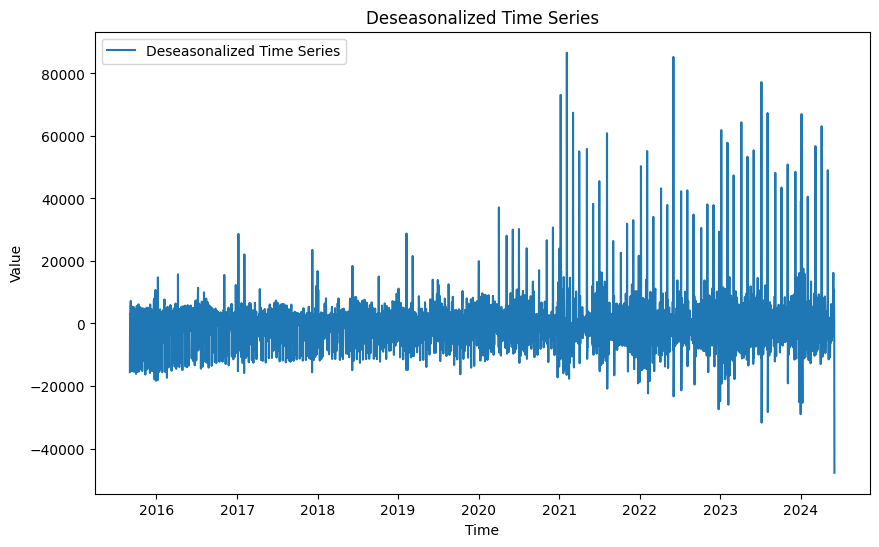

In [101]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_player, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [102]:
viewer = data_diff['Peak viewers']

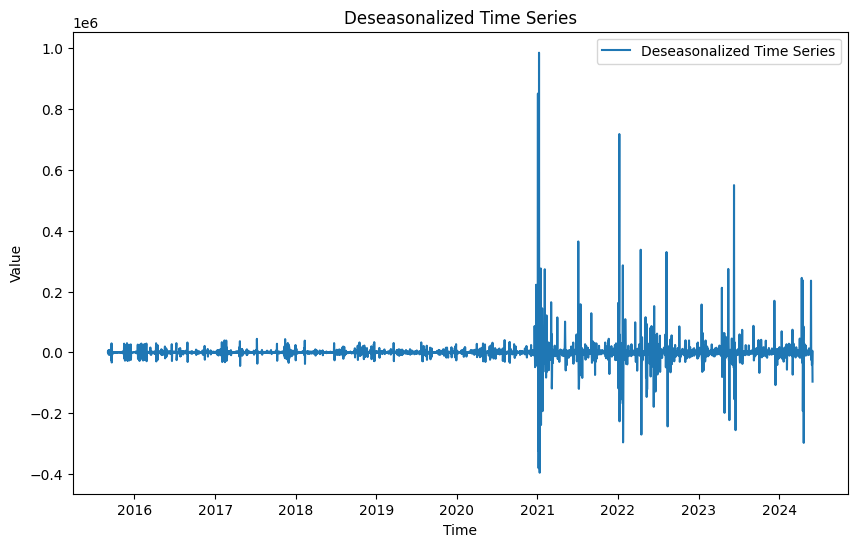

In [103]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(viewer, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [104]:
df = pd.concat([deseasonalized_player, viewer], axis=1)

In [105]:
df.columns = ['deseasonalized_player_diff', 'viewer_diff']

In [106]:
type(df['deseasonalized_player_diff'].values)

numpy.ndarray

In [107]:
dt = np.column_stack((df['viewer_diff'].values, df['deseasonalized_player_diff'].values))

In [108]:
dt

array([[   572.        , -15563.97888058],
       [  -489.        ,   2966.8280268 ],
       [  6722.        ,  -1606.97699675],
       ...,
       [-38653.        ,  10793.02111942],
       [  5294.        ,   -311.1719732 ],
       [-96208.        , -47736.97699675]])

In [109]:
var_names = ['viewer_diff', 'deseasonalized_player_diff']

In [110]:
dataframe = pp.DataFrame(dt, var_names=var_names)
tau_max = 14

# Set up PCMCI with ParCorr (Partial Correlation) as the independence test
parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=1)

# Run Latent PCMCI (this step is a placeholder; actual implementation may vary)
results = lpcmci.run_lpcmci(tau_max=tau_max, pc_alpha=0.05)


Starting preliminary phase  1

Starting test phase

p = 0
(0,-14) independent (0, 0) given () union set()
(0,-12) independent (0, 0) given () union set()
(0,-11) independent (0, 0) given () union set()
(0,-7) independent (0, 0) given () union set()
(0,-2) independent (0, 0) given () union set()
(1,-13) independent (1, 0) given () union set()
(1,-8) independent (1, 0) given () union set()
(1,-6) independent (1, 0) given () union set()
Writing:   (0,-14) oL> (0, 0) ==> (0,-14)     (0, 0) 
Writing:   (0,-12) oL> (0, 0) ==> (0,-12)     (0, 0) 
Writing:   (0,-11) oL> (0, 0) ==> (0,-11)     (0, 0) 
Writing:   (0,-7) oL> (0, 0) ==> (0,-7)     (0, 0) 
Writing:   (0,-2) oL> (0, 0) ==> (0,-2)     (0, 0) 
Writing:   (1,-13) oL> (1, 0) ==> (1,-13)     (1, 0) 
Writing:   (1,-8) oL> (1, 0) ==> (1,-8)     (1, 0) 
Writing:   (1,-6) oL> (1, 0) ==> (1,-6)     (1, 0) 
(0,-1) independent (1, 0) given () union set()
Writing:   (0,-1) oL> (1, 0) ==> (0,-1)     (1, 0) 
(0,-2) independent (1, 0) given () uni


Test phase complete
p = 6

Test phase complete
p = 7

Test phase complete
p = 8

Test phase complete
p = 9

Test phase complete
p = 10
Writing:   (0,-4) <!> (1, 0) ==> (0,-4) <-> (1, 0) 

Test phase complete
p = 11

Test phase complete
p = 12

Test phase complete
p = 13

Test phase complete
p = 14

Test phase complete
p = 15

Test phase complete
p = 16

Test phase complete
p = 17
Writing:   (1,-2) <!> (1, 0) ==> (1,-2) <-> (1, 0) 

Test phase complete
p = 18
Writing:   (1,-1) <!> (1, 0) ==> (1,-1) <-> (1, 0) 

Test phase complete

Starting orientation phase
with rule list:  [['APR'], ['ER-08'], ['ER-02'], ['ER-01'], ['ER-00-d'], ['ER-00-c'], ['ER-03'], ['R-04'], ['ER-09'], ['ER-10'], ['ER-00-b'], ['ER-00-a']]

APR:
Found nothing

ER-08:
Found nothing

ER-02:
Found nothing

ER-01:
Found nothing

ER-00-d:
Found nothing

ER-00-c:
Found nothing

ER-03:
Found nothing

R-04:
Found nothing

ER-09:
Found nothing

ER-10:
Found nothing

ER-00-b:
Found nothing

ER-00-a:
Found nothing

Orientatio

In [111]:
p_matrix = results['p_matrix']
print(results['p_matrix'].round(2))

[[[0.   0.   0.   0.   0.   0.   0.41 0.75 0.06 0.   0.   0.02 0.08 0.04
   0.06]
  [0.   0.98 0.54 0.45 0.   0.93 0.14 0.99 0.57 0.98 0.65 0.14 0.06 0.99
   0.83]]

 [[0.   0.   0.67 0.64 0.68 0.69 0.36 0.44 0.03 0.2  0.12 0.52 0.3  0.6
   0.74]
  [0.   0.   0.   0.18 0.   0.   0.98 0.   0.99 0.75 0.07 0.07 0.97 0.52
   0.  ]]]


In [112]:
def print_significant_causality(p_matrix, alpha=0.05):
    """
    Prints out significant causal links from the p_matrix.

    Parameters:
    - p_matrix: numpy array of shape (N, N, tau_max+1), p-values of the causal links
    - alpha: significance level to determine significant causality
    """
    N, _, tau_max_plus_1 = p_matrix.shape
    tau_max = tau_max_plus_1 - 1

    print(f"Significant causal links (p < {alpha}):")
    for i in range(N):
        for j in range(N):
            for tau in range(tau_max_plus_1):
                p_value = p_matrix[i, j, tau]
                if p_value < alpha:
                    print(f"Variable {i} at time t-{tau} -> Variable {j} at time t with p-value: {p_value:.5f}")


In [113]:
print_significant_causality(p_matrix, alpha=0.05)

Significant causal links (p < 0.05):
Variable 0 at time t-0 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-1 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-2 -> Variable 0 at time t with p-value: 0.00015
Variable 0 at time t-3 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-4 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-5 -> Variable 0 at time t with p-value: 0.00040
Variable 0 at time t-9 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-10 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-11 -> Variable 0 at time t with p-value: 0.01769
Variable 0 at time t-13 -> Variable 0 at time t with p-value: 0.03623
Variable 0 at time t-0 -> Variable 1 at time t with p-value: 0.00000
Variable 0 at time t-4 -> Variable 1 at time t with p-value: 0.00105
Variable 1 at time t-0 -> Variable 0 at time t with p-value: 0.00000
Variable 1 at time t-1 -> Variable 0 at time t with p-value: 0.

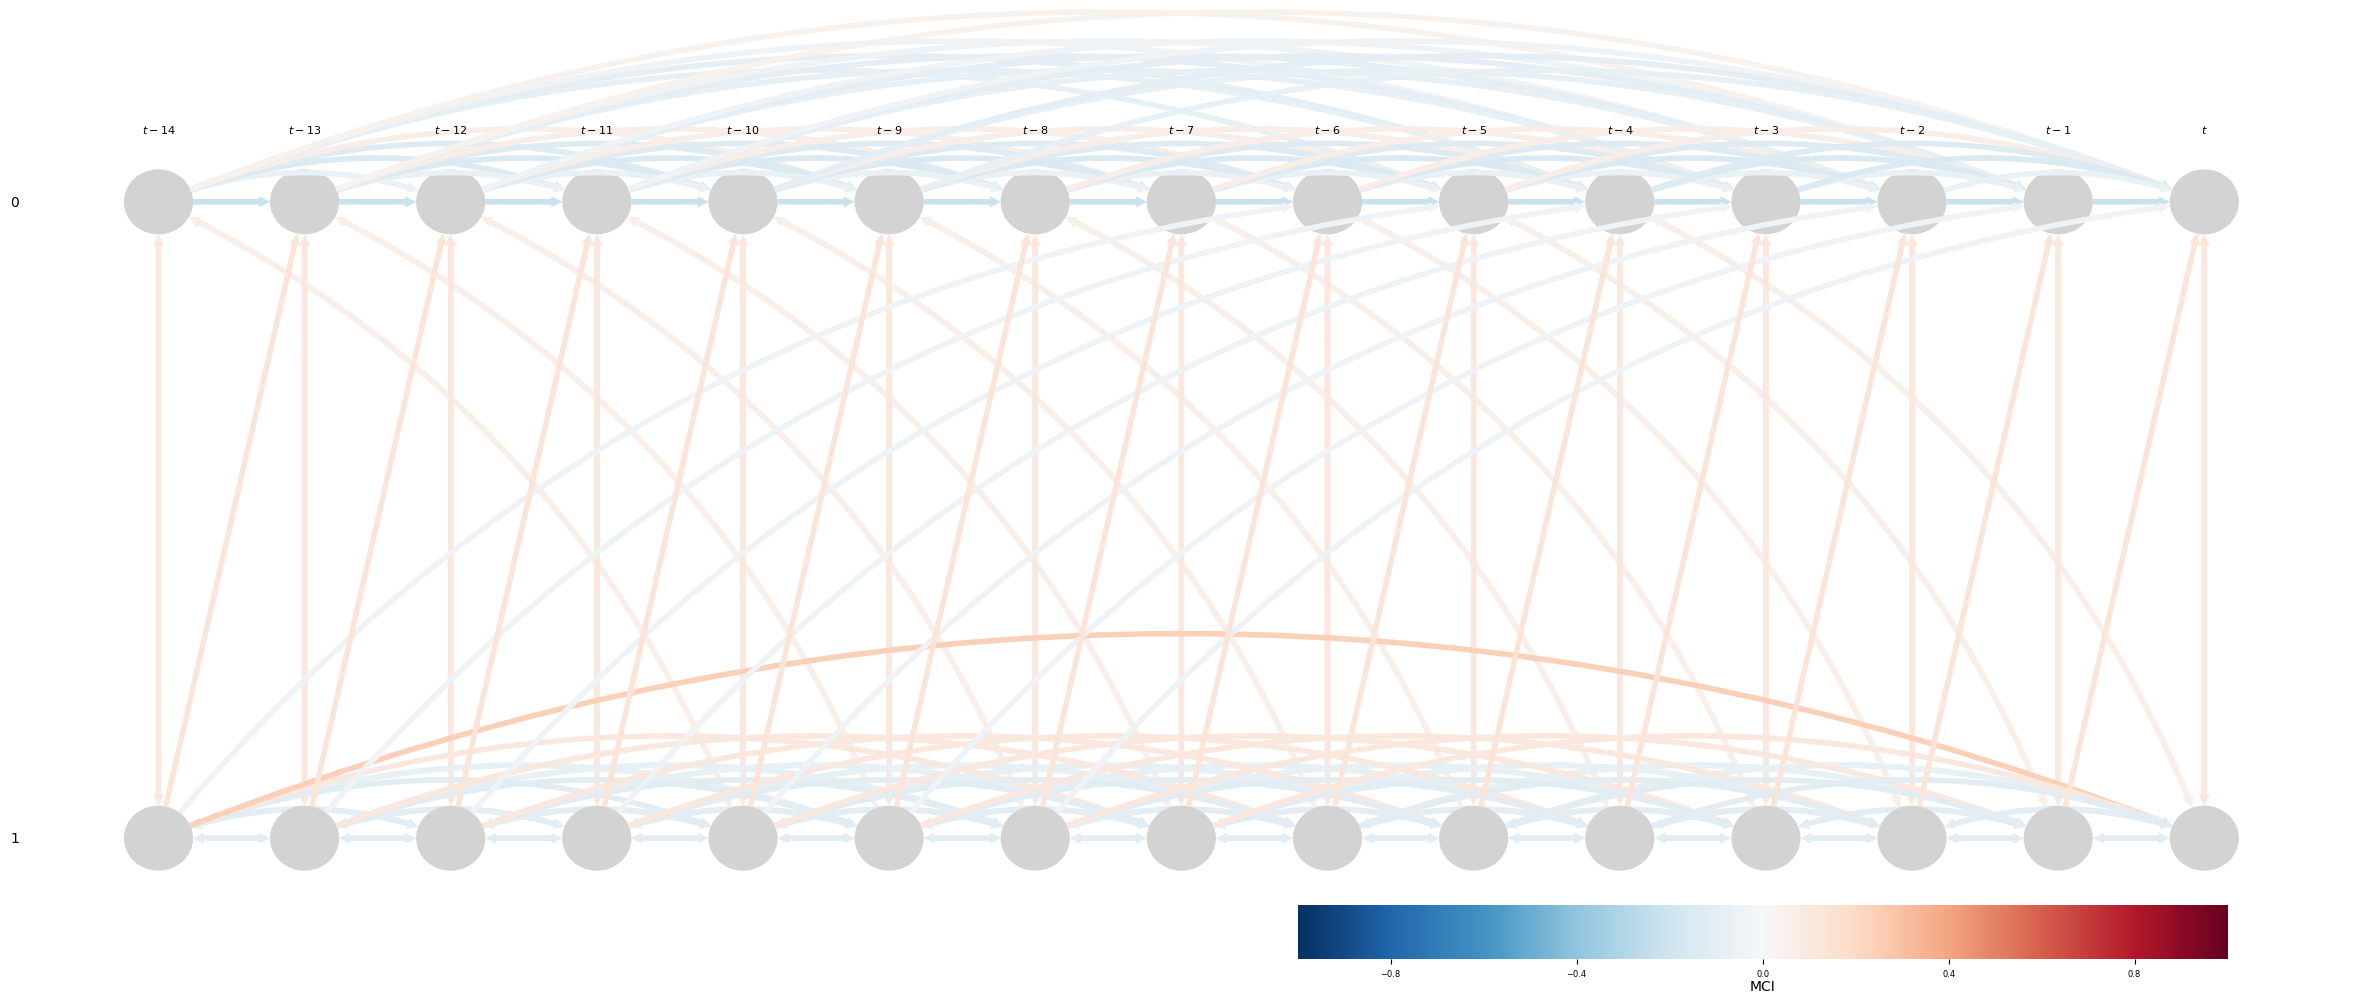

In [114]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'],
                         figsize = (30,10))
plt.savefig(f"{'C:/Users/Yixuan Liu/Downloads/DSO 585'}/time_series_dag_rust.png")
plt.show()

In [115]:
graph = results['graph']

In [116]:
graph

array([[['', '-->', '-->', '-->', '-->', '-->', '', '', '', '-->',
         '-->', '-->', '', '-->', ''],
        ['<->', '', '', '', '<->', '', '', '', '', '', '', '', '', '',
         '']],

       [['<->', '-->', '', '', '', '', '', '', '-->', '', '', '', '',
         '', ''],
        ['', '<->', '<->', '', '-->', '<->', '', '-->', '', '', '', '',
         '', '', '-->']]], dtype='<U3')

In [117]:
# Create the simplified graph based on the significant relationships
simplified_graph = np.array([[['', '-->', '-->', '-->', '-->', '-->', '', '', '', '-->',
         '-->', '', '', '', ''],
        ['', '', '', '', '-->', '', '', '', '', '', '', '', '', '',
         '']],

       [['', '-->', '', '', '', '', '', '', '', '', '', '', '',
         '', ''],
        ['', '-->', '-->', '', '-->', '-->', '', '-->', '', '', '', '',
         '', '', '-->']]], dtype='<U3')


In [118]:
(simplified_graph != graph).flatten().sum()

9

In [119]:
graph != ''

array([[[False,  True,  True,  True,  True,  True, False, False, False,
          True,  True,  True, False,  True, False],
        [ True, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False]],

       [[ True,  True, False, False, False, False, False, False,  True,
         False, False, False, False, False, False],
        [False,  True,  True, False,  True,  True, False,  True, False,
         False, False, False, False, False,  True]]])

In [120]:
(graph != '').flatten().sum()

20

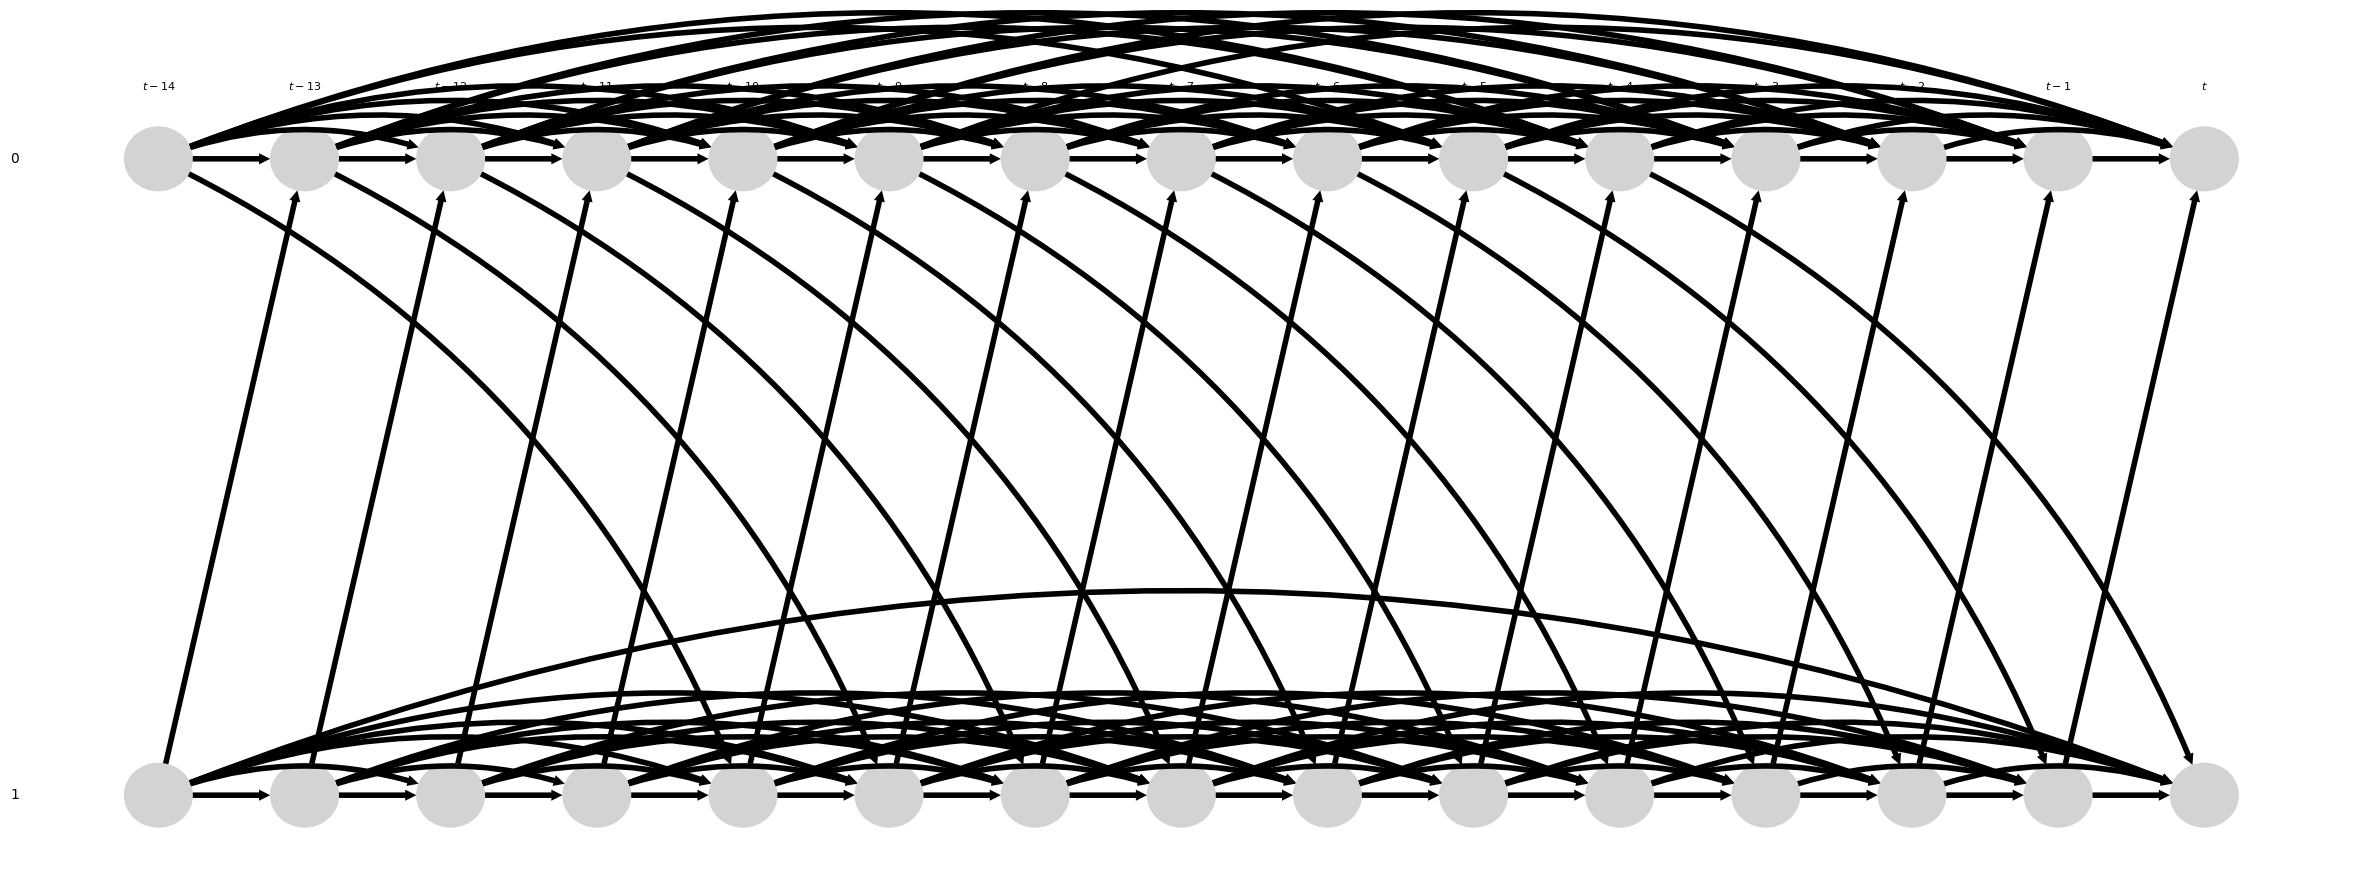

In [121]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=simplified_graph,
                         figsize = (30,10))
plt.savefig(f"{'C:/Users/Yixuan Liu/Downloads/DSO 585'}/time_series_dag_rust_pruned.png")
plt.show()

In [122]:
# Define the cause (X) and effect (Y) variables based on simplified graph
X = [(0, 0), (0, -4)]  # predictor at lag -1 and lag -14
Y = [(1, 0)]  # target at current time
hidden_variables = []

# Initialize the CausalEffects object
causal_effects = CausalEffects(
    graph=simplified_graph,
    graph_type='stationary_dag',
    X=X,
    Y=Y,
    S=None,
    hidden_variables=[]
)

In [123]:
optimal_adjustment_set = causal_effects.get_optimal_set()

In [124]:
optimal_adjustment_set

[(1, -4), (1, -1), (1, -14), (1, -5), (1, -2), (1, -7)]

In [125]:
# Fit the causal effect model
causal_effects.fit_total_effect(
    dataframe=dataframe,
    estimator=LinearRegression(),
    adjustment_set='optimal',  # Use optimal adjustment set
)

In [126]:

# Define `intervention_data` with the correct shape
# intervention_data should have the same number of columns as the length of X
intervention_data = np.ones((1, len(X)))  # Set the predictor to 1

# Predict the total effect of the intervention
y1 = causal_effects.predict_total_effect(intervention_data=intervention_data)
print("Predicted effect when predictor is 1: ", y1)

# Predict the effect of an intervention (setting predictor to 0)
intervention_data_zero = np.zeros((1, len(X)))  # Set the predictor to 0
y0 = causal_effects.predict_total_effect(intervention_data=intervention_data_zero)
print("Predicted effect when predictor is 0: ", y0)
# Calculate the average treatment effect
beta = (y1 - y0)
print("Estimated causal effect = %.4f" % beta)

Predicted effect when predictor is 1:  [16.94357512]
Predicted effect when predictor is 0:  [16.90181859]
Estimated causal effect = 0.0418
